Ignore Warning  

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

Data Acquisitions

In [ ]:
#from google.colab import drive
#drive.mount("/content/drive")

In [ ]:
PROJECT_PATH = "/content/drive/MyDrive/Cancer"

In [ ]:
#!pip install -q kaggle
#import os
#os.environ['KAGGLE_CONFIG_DIR'] = PROJECT_PATH

In [ ]:
#%cd /content/drive/MyDrive/Cancer
#!kaggle datasets download -d shivam17299/oral-cancer-lips-and-tongue-images

In [ ]:
#!unzip -q oral-cancer-lips-and-tongue-images.zip -d "Oral Cancer"

**Configuration**

In [ ]:
#DATASET_PATH = "/content/drive/MyDrive/Cancer/Oral Cancer/OralCancer"
#CLASSES = ["cancer", "non-cancer"]
#NEW_SIZE = (32, 32, 3)
#TRAIN_SIZE = 0.8
#POPULATION_SIZE = 5
#NO_OF_ITERATIONS = 3
#LOWER_BOUND = 0.0
#UPPER_BOUND = 1.0
#EPOCHS = 15
#PATIENCE = 7

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/Cancer/Oral Cancer/OralCancer"
CLASSES = ["cancer", "non-cancer"]
NEW_SIZE = (64, 64, 3)
TRAIN_SIZE = 0.8
POPULATION_SIZE = 8
NO_OF_ITERATIONS = 5
LOWER_BOUND = 0.0
UPPER_BOUND = 1.0
EPOCHS = 5
PATIENCE = 7

**Helper Functions**

In [ ]:
import matplotlib.pyplot as plt

def DisplayColorImage(image):
  newImage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  f = plt.figure()
  plt.imshow(newImage)
  plt.show()
  plt.close()

def PlotHistory(history):
  f = plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title("Accuracy Curve")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(["Train", "Validation"])
  plt.grid("both")
  plt.show()
  plt.close()

**Read Data**

In [ ]:
import cv2, os
X = []
y = []
counter = {"cancer": 0, "non-cancer": 0}

for cls in CLASSES:
  clsContent = os.listdir(os.path.join(DATASET_PATH, cls))
  for imgName in clsContent:
    imgPath = os.path.join(DATASET_PATH, cls, imgName)
    image = cv2.imread(imgPath)
    image = cv2.resize(image, NEW_SIZE[:2], interpolation=cv2.INTER_CUBIC)
    X.append(image)
    y.append(cls)
    counter[cls] += 1

print(len(X), len(y))
print(counter)

131 131
{'cancer': 87, 'non-cancer': 44}


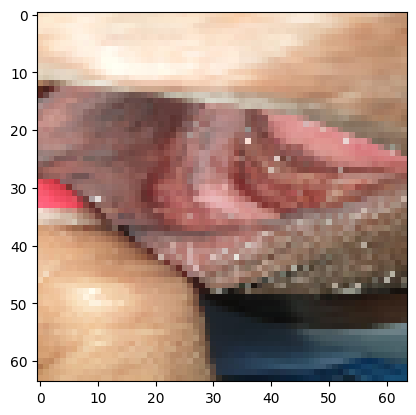

In [ ]:
DisplayColorImage(X[0])

**Data Augmentation/Balancing**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
dataGen = ImageDataGenerator(
  rotation_range=25,
  width_shift_range=0.2,
  height_shift_range=0.2,
  zoom_range=0.2,
  shear_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
)

In [ ]:
noncancerX = [X[i] for i in range(len(X)) if y[i] == "non-cancer"]
dataGen.fit(noncancerX)

(64, 64, 3)


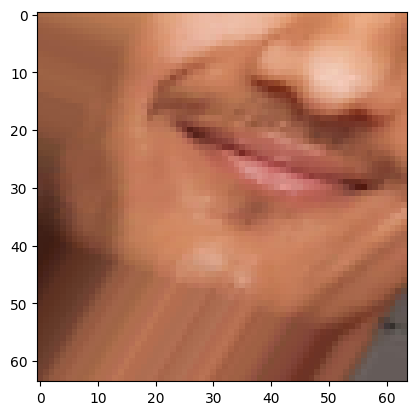

In [ ]:
import numpy as np
diff = counter["cancer"] - counter["non-cancer"]
imgGenerator = dataGen.flow(np.array(noncancerX), batch_size=1)
newImage = next(imgGenerator)[0].astype("uint8")
print(newImage.shape)
DisplayColorImage(newImage)
#print(newImage)

In [ ]:
for i in range(diff):
  newImage = next(imgGenerator)[0].astype("uint8")
  X.append(newImage)
  y.append("non-cancer")
  counter["non-cancer"] += 1

print(counter)

{'cancer': 87, 'non-cancer': 87}


In [ ]:
X = np.array(X) / 255.0 # Normalization

In [ ]:
from sklearn.preprocessing import LabelEncoder
objEnc = LabelEncoder()
yEnc = objEnc.fit_transform(y)
print(y[0], yEnc[0])

cancer 0


**Data Split**

In [ ]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(np.array(X), yEnc, train_size=TRAIN_SIZE, stratify=yEnc)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, train_size=TRAIN_SIZE, stratify=trainY)
print(trainX.shape)
print(testX.shape)
print(valX.shape)

(111, 64, 64, 3)
(35, 64, 64, 3)
(28, 64, 64, 3)


Trials


In [ ]:
#!pip install keras==2.11.0
#!pip install tensorflow==2.11.0

**Learning and Optimization**

In [ ]:
from tensorflow.keras.optimizers.legacy import *

ranges = {
  "Rotation": np.arange(0, 31, 1),
  "Width Shift": np.arange(0, 0.21, 0.1),
  "Height Shift": np.arange(0, 0.21, 0.1),
  "Zoom": np.arange(0, 0.21, 0.1),
  "Shear": np.arange(0, 0.21, 0.1),
  "Horizontal Flip": [True, False],
  "Vertical Flip": [True, False],
  "Optimizer": [Adam(), Nadam(), RMSprop(), Adadelta(), Adagrad(), SGD()],
  "Batch Size": [8, 16, 32, 64],
  "TL Learn Ratio": np.arange(0, 26, 1),
}

SOLUTION_SIZE = len(ranges.keys())

In [ ]:
# Population Initialization
population = np.random.uniform(
  low=LOWER_BOUND,
  high=UPPER_BOUND,
  size=(POPULATION_SIZE, SOLUTION_SIZE)
)
print(population.shape)
print(population[0])


(8, 10)
[0.28105221 0.42768516 0.43294702 0.97404953 0.25839317 0.79561867
 0.06358805 0.07291166 0.26658461 0.99945303]


In [ ]:

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *

# Fitness Function Evaluation
def FitnessFunction(solution):
  solution = np.round(solution, 4)

  index = int(np.round(solution[0] * (len(ranges["Rotation"]) - 1)))
  rotationValue = ranges["Rotation"][index]

  index = int(np.round(solution[1] * (len(ranges["Width Shift"]) - 1)))
  widthShiftValue = ranges["Width Shift"][index]

  index = int(np.round(solution[2] * (len(ranges["Height Shift"]) - 1)))
  heightShiftValue = ranges["Height Shift"][index]

  index = int(np.round(solution[3] * (len(ranges["Zoom"]) - 1)))
  zoomValue = ranges["Zoom"][index]

  index = int(np.round(solution[4] * (len(ranges["Shear"]) - 1)))
  shearValue = ranges["Shear"][index]

  index = int(np.round(solution[5] * (len(ranges["Horizontal Flip"]) - 1)))
  hFlipValue = ranges["Horizontal Flip"][index]

  index = int(np.round(solution[6] * (len(ranges["Vertical Flip"]) - 1)))
  vFlipValue = ranges["Vertical Flip"][index]

  index = int(np.round(solution[7] * (len(ranges["Optimizer"]) - 1)))
  optimizerValue = ranges["Optimizer"][index]

  index = int(np.round(solution[8] * (len(ranges["Batch Size"]) - 1)))
  batchSizeValue = ranges["Batch Size"][index]

  index = int(np.round(solution[9] * (len(ranges["TL Learn Ratio"]) - 1)))
  tlLearnRatioValue = ranges["TL Learn Ratio"][index]

  dataGen = ImageDataGenerator(
    rotation_range=rotationValue,
    width_shift_range=widthShiftValue,
    height_shift_range=heightShiftValue,
    zoom_range=zoomValue,
    shear_range=shearValue,
    horizontal_flip=hFlipValue,
    vertical_flip=vFlipValue,
  )

  baseModel = MobileNet(weights='imagenet', include_top=False, input_tensor=Input(NEW_SIZE))

  x = baseModel.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x)
  predictions = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=baseModel.input, outputs=predictions)
  for layer in baseModel.layers:
    layer.trainable = False

  fromIndex = int(np.round((len(baseModel.layers) - 1) * (1.0 - tlLearnRatioValue / 100.0)))
  for layer in baseModel.layers[fromIndex:]:
    layer.trainable = True

  model.compile(
    optimizer=optimizerValue,
    loss='binary_crossentropy',
    metrics=["accuracy", Precision(), Recall(), AUC(), TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()]
  )

  keyword = "MobileNet-" + "-".join([str(el)[2:] for el in solution])
  checkpointPath = os.path.join(PROJECT_PATH, "Checkpoints", keyword) + ".h5"
  csvLogPath = os.path.join(PROJECT_PATH, "Logs", keyword) + ".csv"
  histroy = model.fit(
    dataGen.flow(trainX, trainY, batch_size=batchSizeValue),
    validation_data=(valX, valY),
    batch_size=batchSizeValue,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[
      ModelCheckpoint(checkpointPath, save_best_only=True, save_weights_only=True, monitor="val_accuracy", mode="max", verbose=0),
      TerminateOnNaN(),
      CSVLogger(csvLogPath, append=True),
      EarlyStopping(monitor="val_accuracy", mode="max", patience=PATIENCE),
    ]
  )

  PlotHistory(histroy)

  model.load_weights(checkpointPath)
  scoresList = model.evaluate(testX, testY, verbose=0)
  score = (scoresList[1] + scoresList[2] + scoresList[3]) / 3.0

  configs = [
    rotationValue,
    widthShiftValue,
    heightShiftValue,
    zoomValue,
    shearValue,
    hFlipValue,
    vFlipValue,
    optimizerValue._name,
    batchSizeValue,
    tlLearnRatioValue,
  ]
  print(scoresList, score, configs)

  return score


In [ ]:

# Population Updating
def PopulationUpdating(population, scores, iterationNumber):
  bestIndex = np.argmax(scores)
  bestSolution = population[bestIndex].copy()
  bestScore = scores[bestIndex]

  # MRFO:
  # Write the metaheuristic rules for updating the population.
  newPopulation = population.copy()

  coef = iterationNumber / float(NO_OF_ITERATIONS)
  for i in range(len(population)):
    r = np.random.random(1)
    alpha = 2.0 * r * np.sqrt(np.abs(np.log(r)))
    r1 = np.random.random(1)
    factor = (NO_OF_ITERATIONS - iterationNumber + 1.0) / (NO_OF_ITERATIONS * 1.0)
    beta = 2.0 * np.exp(r1 * factor) * np.sin(2.0 * np.pi * r1)
    if (np.random.random(1) < 0.5):
      if (coef < np.random.random(1)):
        s = np.subtract(UPPER_BOUND, LOWER_BOUND)
        u = np.random.uniform(low=0, high=1, size=SOLUTION_SIZE)
        m = np.multiply(u, s)
        xRand = np.clip(np.add(LOWER_BOUND, m), LOWER_BOUND, UPPER_BOUND)
        if (i == 0):
          newPopulation[i, :] = xRand + r * (xRand - population[i, :]) + beta * (xRand - population[i, :])
        else:
          newPopulation[i, :] = xRand + r * (population[i - 1, :] - population[i, :]) + beta * (xRand - population[i, :])
      else:
        if (i == 0):
          newPopulation[i, :] = bestSolution + r * (bestSolution - population[i, :]) + beta * (bestSolution - population[i, :])
        else:
          newPopulation[i, :] = bestSolution + r * (population[i - 1, :] - population[i, :]) + beta * (bestSolution - population[i, :])
    else:
      if (i == 0):
        newPopulation[i, :] = population[i, :] + r * (bestSolution - population[i, :]) + alpha * (bestSolution - population[i, :])
      else:
        newPopulation[i, :] = population[i, :] + r * (population[i - 1, :] - population[i, :]) + alpha * (bestSolution - population[i, :])

    newPopulation[i, :] = np.clip(newPopulation[i, :], LOWER_BOUND, UPPER_BOUND)

    currentScore = FitnessFunction(newPopulation[i, :])
    if (currentScore > bestScore):
      bestSolution, bestScore = newPopulation[i, :].copy(), currentScore

    s = 2.0
    r2, r3 = np.random.random(1), np.random.random(1)
    newPopulation[i, :] = population[i, :] + s * (r2 * bestSolution - r3 * population[i, :])

    newPopulation[i, :] = np.clip(newPopulation[i, :], LOWER_BOUND, UPPER_BOUND)

    currentScore = FitnessFunction(newPopulation[i, :])
    if (currentScore > bestScore):
      bestSolution, bestScore = newPopulation[i, :].copy(), currentScore

  return newPopulation.copy()



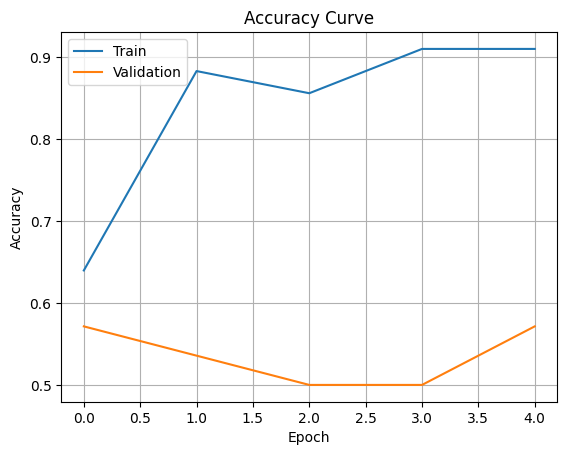

[1.3057719469070435, 0.7142857313156128, 0.6428571343421936, 1.0, 0.8839869499206543, 18.0, 7.0, 10.0, 0.0] 0.7857142885526022 [8, 0.1, 0.1, 0.2, 0.1, False, True, 'Adam', 16, 25]


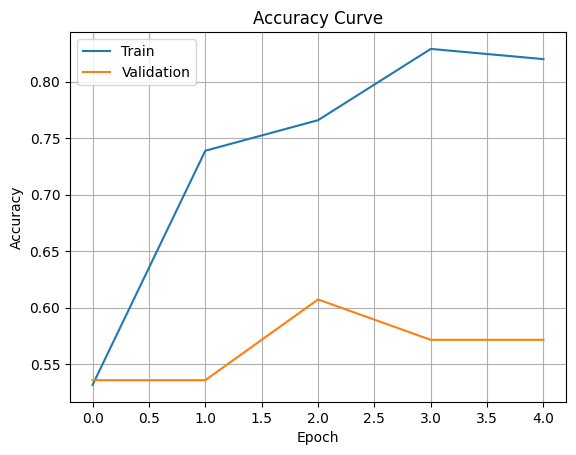

[0.6024893522262573, 0.6571428775787354, 0.6153846383094788, 0.8888888955116272, 0.8120915293693542, 16.0, 7.0, 10.0, 2.0] 0.7204721371332804 [25, 0.0, 0.2, 0.1, 0.1, True, False, 'SGD', 32, 17]


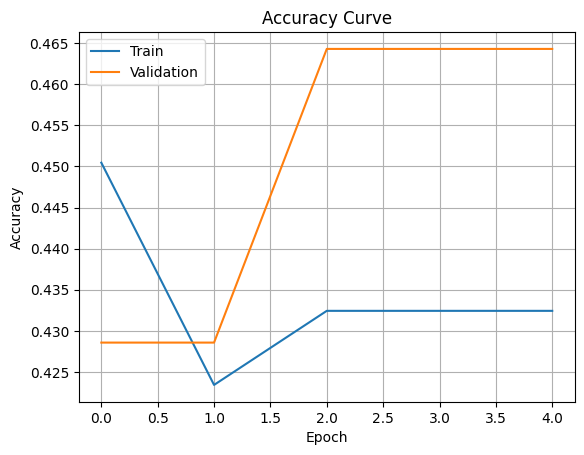

[1.0717562437057495, 0.2857142984867096, 0.36000001430511475, 0.5, 0.25, 9.0, 1.0, 16.0, 9.0] 0.3819047709306081 [23, 0.0, 0.1, 0.1, 0.0, True, False, 'Adadelta', 32, 6]


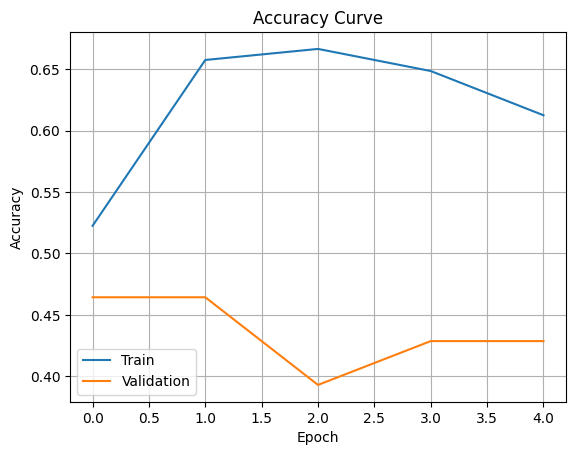

[0.8279517889022827, 0.5714285969734192, 0.5483871102333069, 0.9444444179534912, 0.5359477400779724, 17.0, 3.0, 14.0, 1.0] 0.6880867083867391 [17, 0.1, 0.1, 0.0, 0.1, True, True, 'Adagrad', 32, 13]


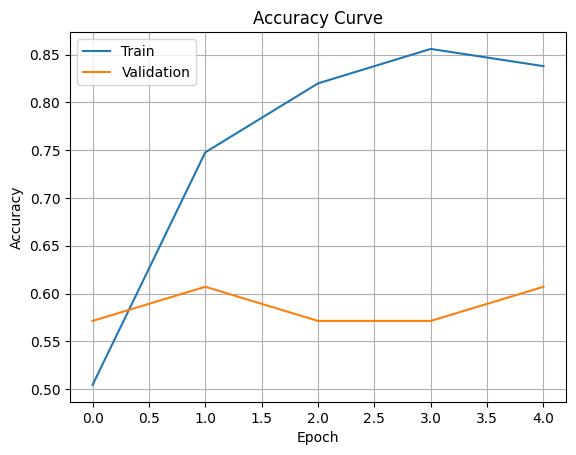

[0.585304856300354, 0.6285714507102966, 0.5806451439857483, 1.0, 0.89705890417099, 18.0, 4.0, 13.0, 0.0] 0.7364055315653483 [19, 0.1, 0.2, 0.1, 0.1, True, True, 'SGD', 16, 13]


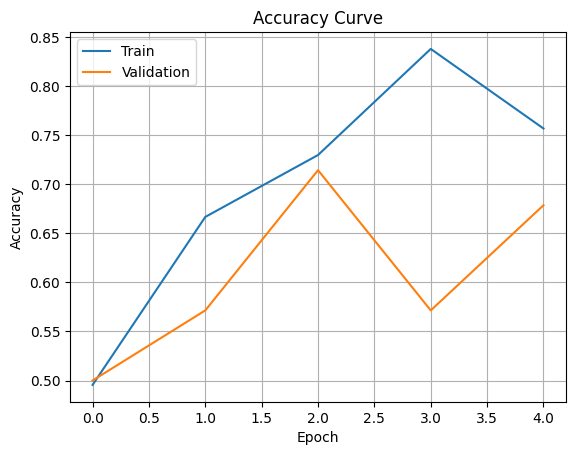

[0.6047561168670654, 0.6000000238418579, 0.6428571343421936, 0.5, 0.7271241545677185, 9.0, 12.0, 5.0, 9.0] 0.5809523860613505 [7, 0.0, 0.1, 0.1, 0.1, True, True, 'SGD', 64, 15]


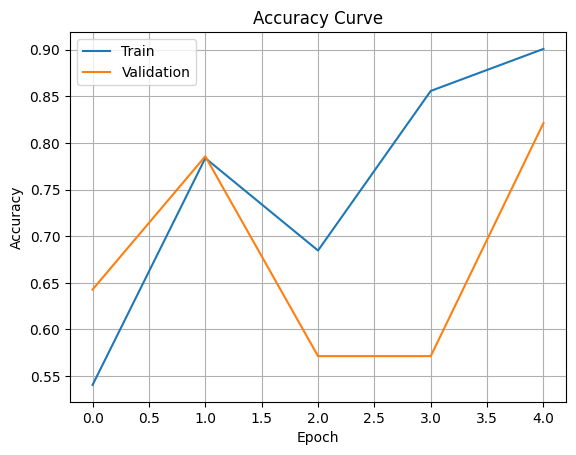

[0.3674003481864929, 0.8285714387893677, 0.7727272510528564, 0.9444444179534912, 0.9493464231491089, 17.0, 12.0, 5.0, 1.0] 0.8485810359319051 [26, 0.1, 0.1, 0.1, 0.0, False, True, 'SGD', 16, 24]


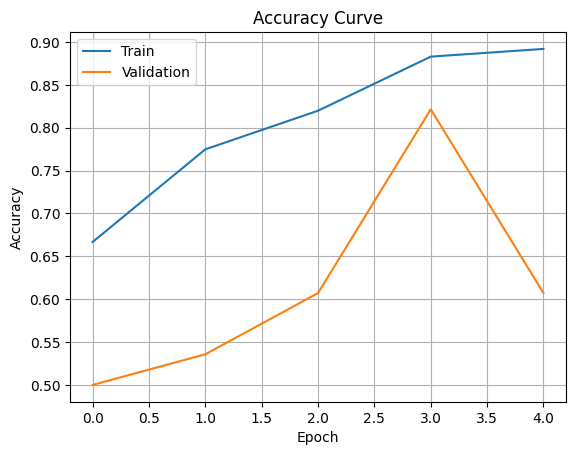

[0.4179639518260956, 0.8285714387893677, 0.800000011920929, 0.8888888955116272, 0.9379084706306458, 16.0, 13.0, 4.0, 2.0] 0.8391534487406412 [17, 0.1, 0.1, 0.1, 0.1, False, False, 'Nadam', 8, 15]


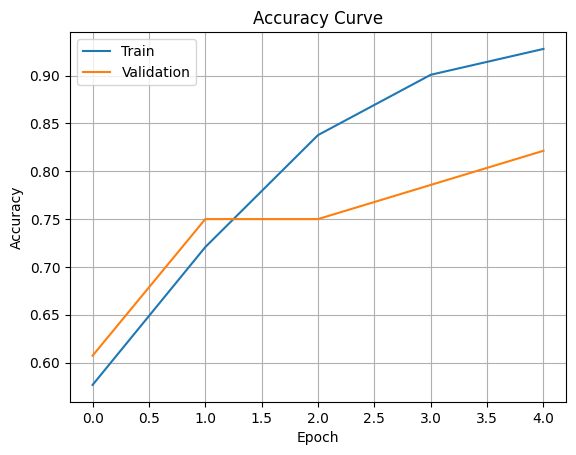

[0.44895631074905396, 0.8857142925262451, 0.9375, 0.8333333134651184, 0.9199346303939819, 15.0, 16.0, 1.0, 3.0] 0.8855158686637878 [30, 0.2, 0.2, 0.0, 0.2, True, False, 'Adam', 64, 0]


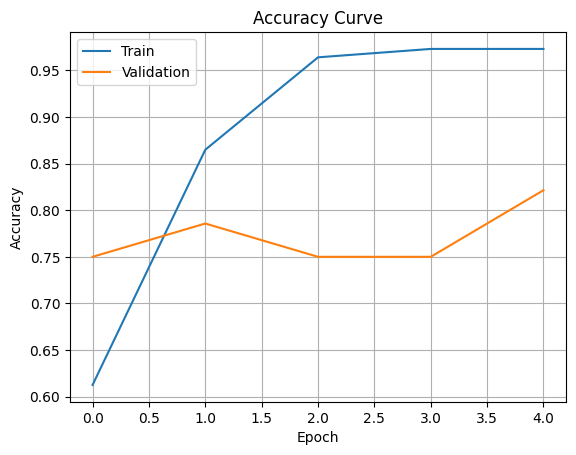

[0.3298225402832031, 0.9428571462631226, 0.9444444179534912, 0.9444444179534912, 0.9395424127578735, 17.0, 16.0, 1.0, 1.0] 0.943915327390035 [1, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


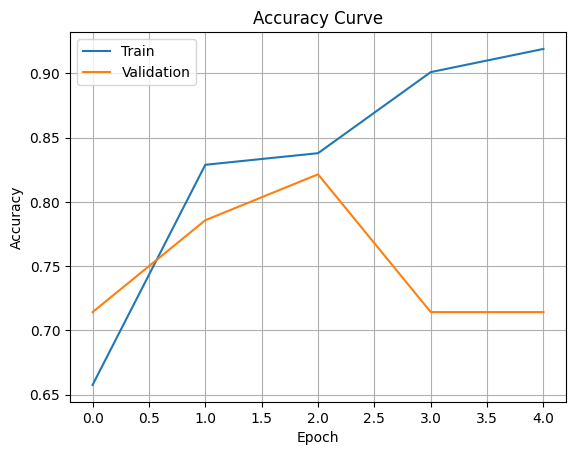

[0.24663345515727997, 0.9142857193946838, 0.8947368264198303, 0.9444444179534912, 0.9803921580314636, 17.0, 15.0, 2.0, 1.0] 0.9178223212560018 [0, 0.2, 0.0, 0.2, 0.2, False, True, 'Adam', 8, 0]


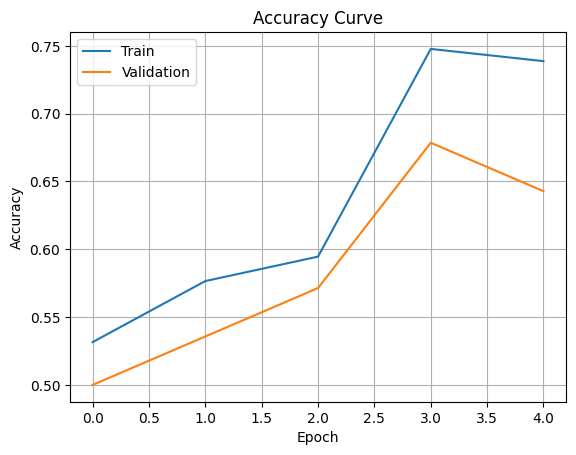

[0.5270421504974365, 0.7428571581840515, 0.7647058963775635, 0.7222222089767456, 0.8578431606292725, 13.0, 13.0, 4.0, 5.0] 0.7432617545127869 [20, 0.0, 0.1, 0.1, 0.1, True, False, 'Adagrad', 32, 13]


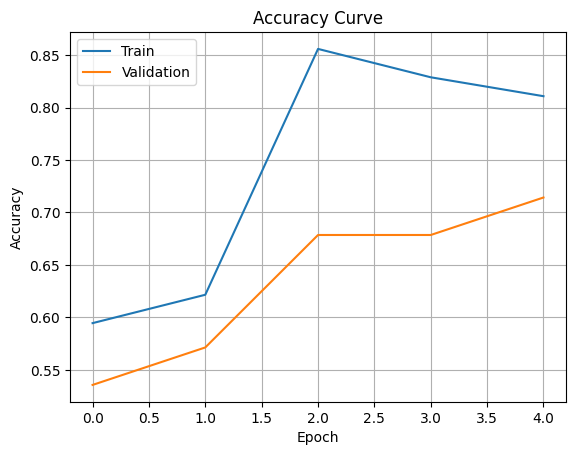

[0.4033482074737549, 0.8857142925262451, 1.0, 0.7777777910232544, 0.9477124810218811, 14.0, 17.0, 0.0, 4.0] 0.8878306945164999 [27, 0.0, 0.0, 0.2, 0.2, False, True, 'Adam', 8, 23]


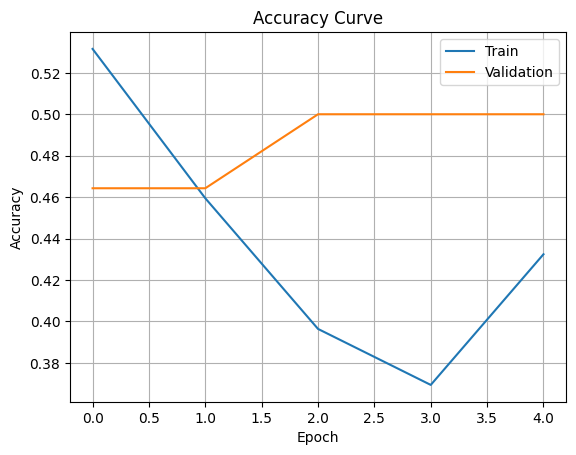

[0.8001139760017395, 0.48571428656578064, 0.5, 0.7777777910232544, 0.5114379525184631, 14.0, 3.0, 14.0, 4.0] 0.5878306925296783 [20, 0.0, 0.1, 0.1, 0.0, True, False, 'Adadelta', 32, 5]


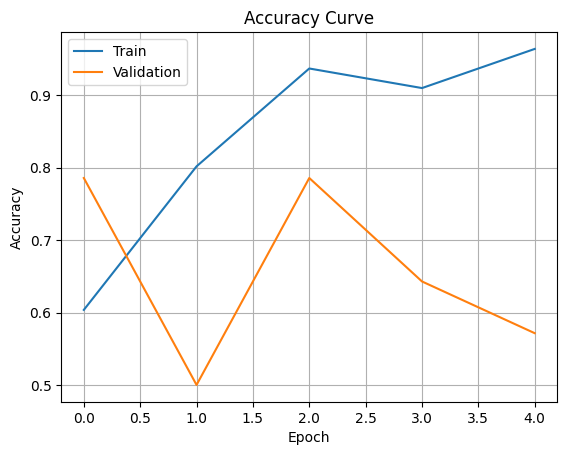

[0.31795209646224976, 0.7714285850524902, 0.8571428656578064, 0.6666666865348816, 0.9526143074035645, 12.0, 15.0, 2.0, 6.0] 0.7650793790817261 [11, 0.0, 0.0, 0.0, 0.0, True, True, 'RMSprop', 16, 7]


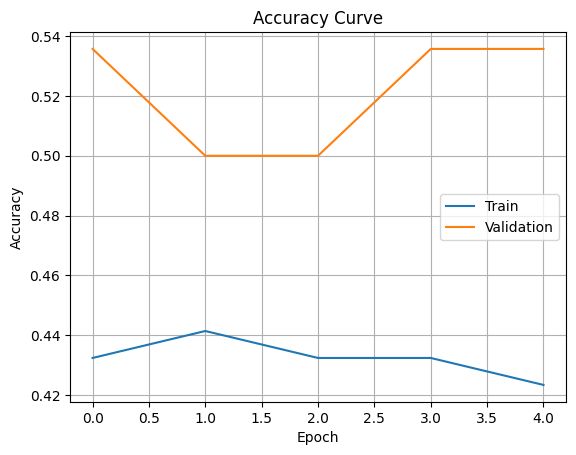

[0.6897701621055603, 0.6285714507102966, 0.7272727489471436, 0.4444444477558136, 0.6830065250396729, 8.0, 14.0, 3.0, 10.0] 0.600096215804418 [12, 0.0, 0.0, 0.0, 0.1, True, True, 'Adadelta', 16, 9]


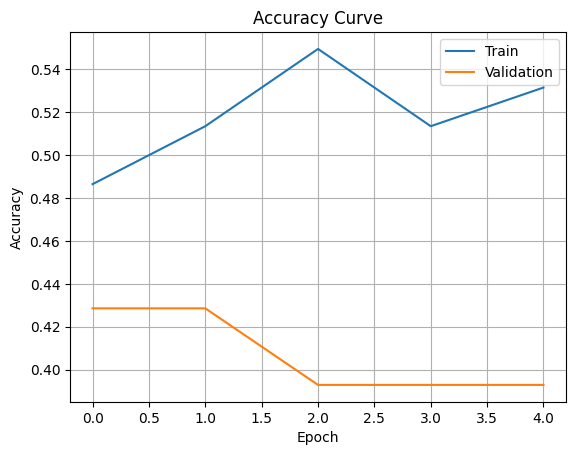

[0.792117178440094, 0.48571428656578064, 0.5, 0.5, 0.45588237047195435, 9.0, 8.0, 9.0, 9.0] 0.4952380955219269 [9, 0.0, 0.1, 0.1, 0.2, False, False, 'Adadelta', 64, 25]


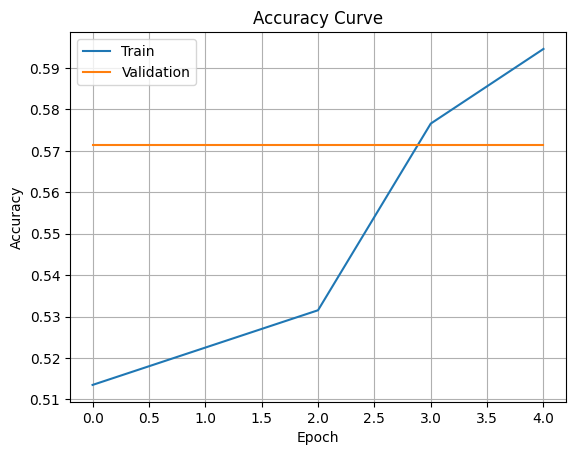

[0.6594802141189575, 0.5714285969734192, 0.6153846383094788, 0.4444444477558136, 0.630719006061554, 8.0, 12.0, 5.0, 10.0] 0.5437525610129038 [15, 0.1, 0.1, 0.1, 0.1, True, True, 'Adadelta', 16, 9]


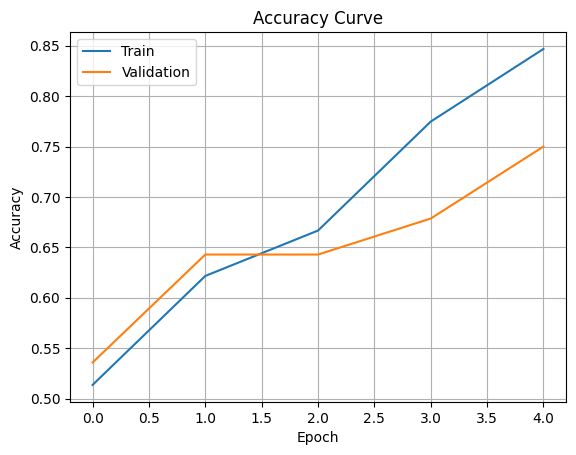

[0.581944465637207, 0.6857143044471741, 0.6666666865348816, 0.7777777910232544, 0.7565359473228455, 14.0, 10.0, 7.0, 4.0] 0.7100529273351034 [15, 0.0, 0.0, 0.1, 0.2, True, True, 'SGD', 64, 25]


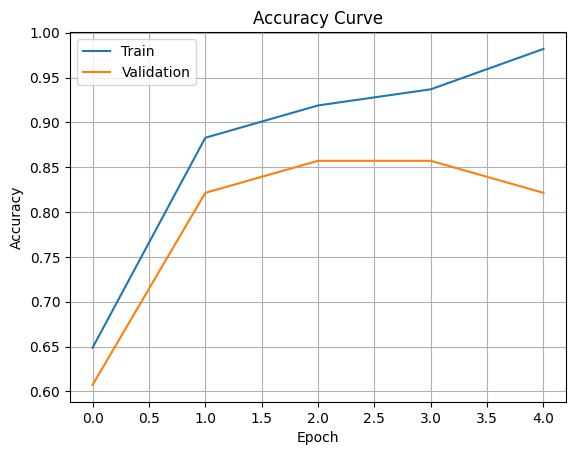

[0.3809303343296051, 0.8285714387893677, 0.7727272510528564, 0.9444444179534912, 0.9640523195266724, 17.0, 12.0, 5.0, 1.0] 0.8485810359319051 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


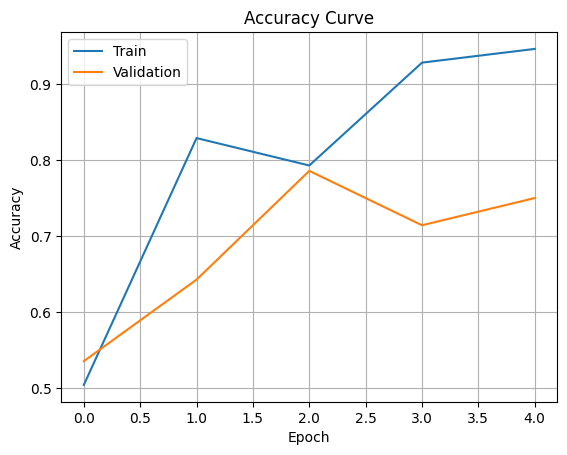

[0.6886684894561768, 0.7714285850524902, 0.7083333134651184, 0.9444444179534912, 0.9183006882667542, 17.0, 10.0, 7.0, 1.0] 0.8080687721570333 [0, 0.0, 0.0, 0.0, 0.0, True, False, 'Adam', 64, 0]


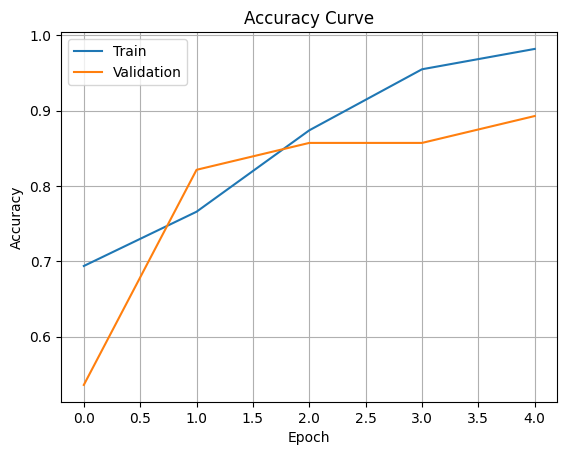

[0.19927668571472168, 0.8857142925262451, 0.8500000238418579, 0.9444444179534912, 0.9771242141723633, 17.0, 14.0, 3.0, 1.0] 0.8933862447738647 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


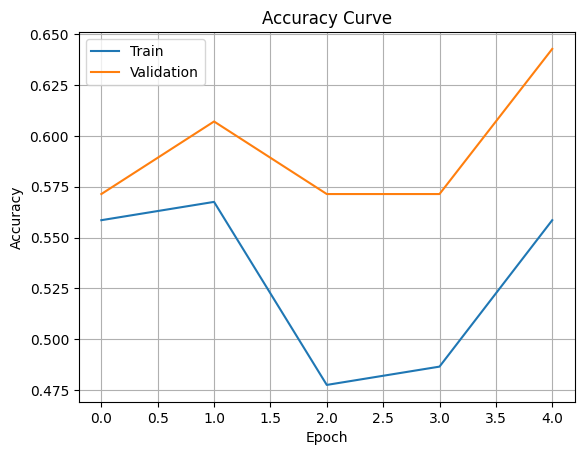

[0.7098650932312012, 0.5428571701049805, 0.5357142686843872, 0.8333333134651184, 0.6339869499206543, 15.0, 4.0, 13.0, 3.0] 0.6373015840848287 [19, 0.0, 0.2, 0.0, 0.1, True, True, 'Adadelta', 8, 18]


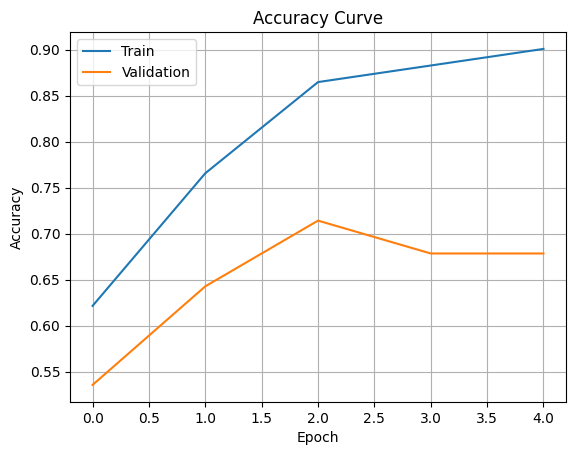

[0.35295340418815613, 0.8571428656578064, 0.8823529481887817, 0.8333333134651184, 0.9248366951942444, 15.0, 15.0, 2.0, 3.0] 0.8576097091039022 [17, 0.1, 0.1, 0.1, 0.1, False, False, 'Nadam', 8, 14]


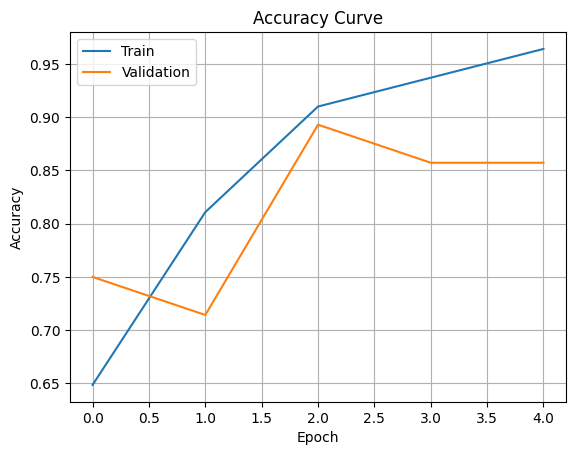

[0.27464306354522705, 0.9142857193946838, 0.8947368264198303, 0.9444444179534912, 0.9722222685813904, 17.0, 15.0, 2.0, 1.0] 0.9178223212560018 [1, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


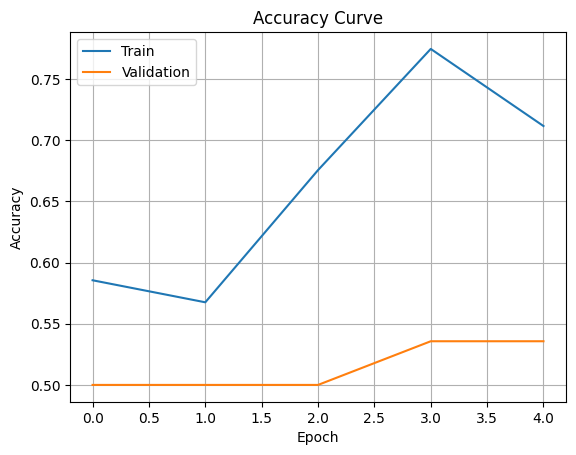

[0.7812929153442383, 0.6000000238418579, 0.5714285969734192, 0.8888888955116272, 0.6274510025978088, 16.0, 5.0, 12.0, 2.0] 0.6867725054423014 [20, 0.0, 0.1, 0.1, 0.1, True, False, 'Adagrad', 32, 13]


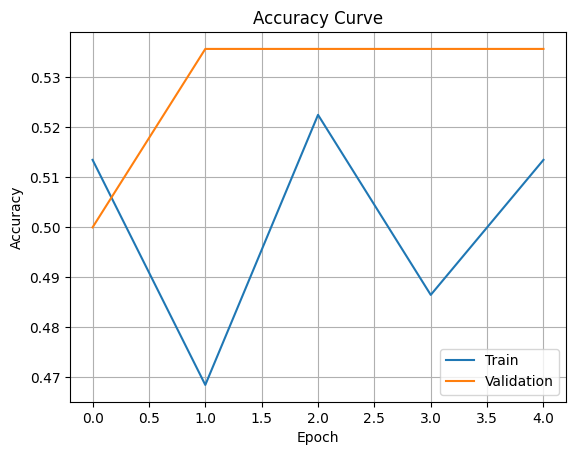

[1.005260705947876, 0.5142857432365417, 0.5142857432365417, 1.0, 0.5457516312599182, 18.0, 0.0, 17.0, 0.0] 0.6761904954910278 [20, 0.0, 0.1, 0.1, 0.0, True, False, 'Adadelta', 32, 5]


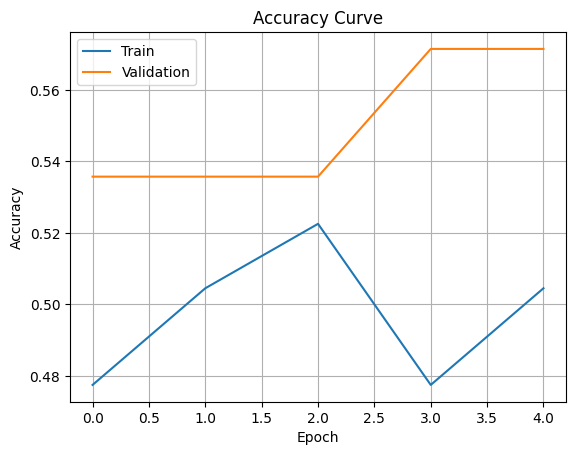

[0.9872069358825684, 0.5428571701049805, 0.529411792755127, 1.0, 0.4852941334247589, 18.0, 1.0, 16.0, 0.0] 0.6907563209533691 [12, 0.0, 0.0, 0.0, 0.1, True, True, 'Adadelta', 16, 9]


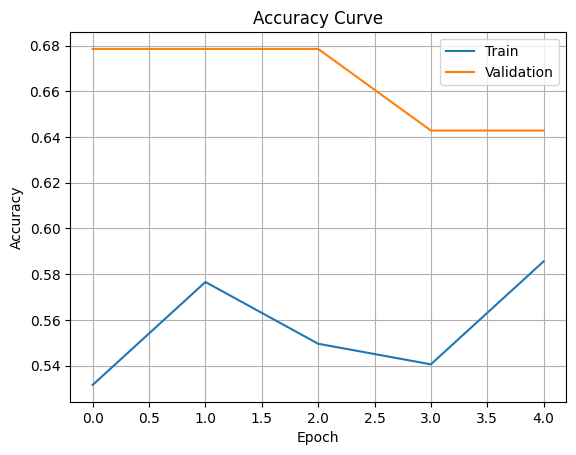

[0.6807543039321899, 0.6285714507102966, 0.6666666865348816, 0.5555555820465088, 0.665032684803009, 10.0, 12.0, 5.0, 8.0] 0.6169312397638956 [15, 0.1, 0.1, 0.1, 0.1, True, True, 'Adadelta', 16, 9]


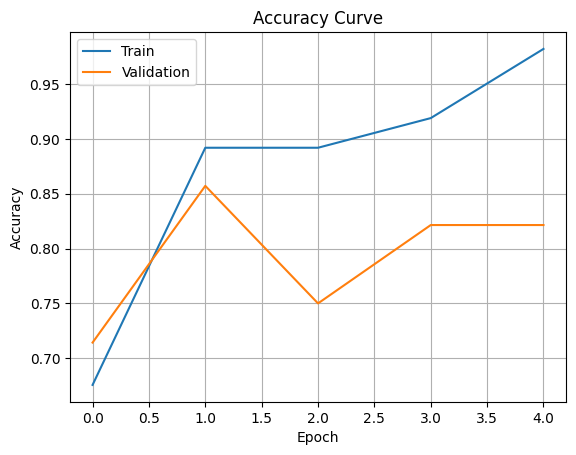

[0.19428277015686035, 0.9142857193946838, 0.9411764740943909, 0.8888888955116272, 0.9836601614952087, 16.0, 16.0, 1.0, 2.0] 0.9147836963335673 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


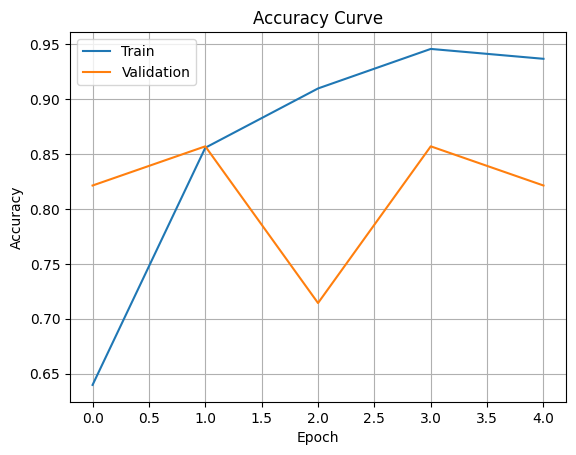

[0.47767186164855957, 0.8571428656578064, 0.782608687877655, 1.0, 0.898692786693573, 18.0, 12.0, 5.0, 0.0] 0.8799171845118204 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


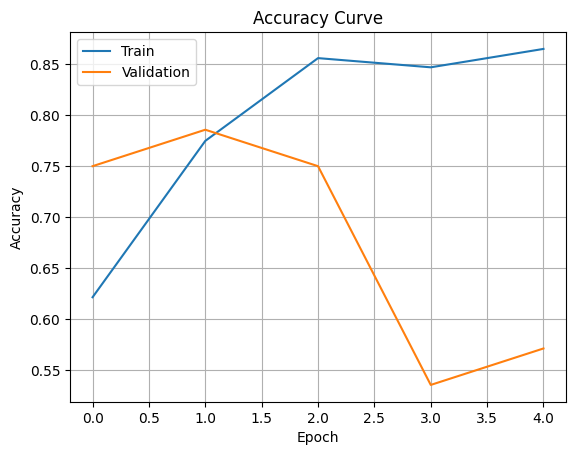

[0.46250778436660767, 0.7714285850524902, 0.8571428656578064, 0.6666666865348816, 0.8856208920478821, 12.0, 15.0, 2.0, 6.0] 0.7650793790817261 [17, 0.1, 0.1, 0.1, 0.1, False, False, 'Nadam', 8, 14]


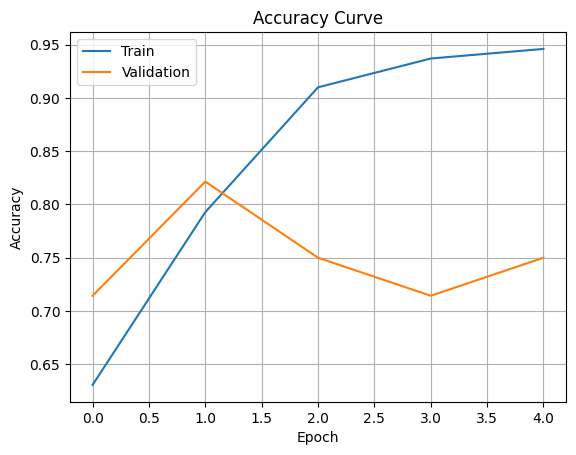

[1.398833990097046, 0.7714285850524902, 0.7083333134651184, 0.9444444179534912, 0.8692810535430908, 17.0, 10.0, 7.0, 1.0] 0.8080687721570333 [1, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


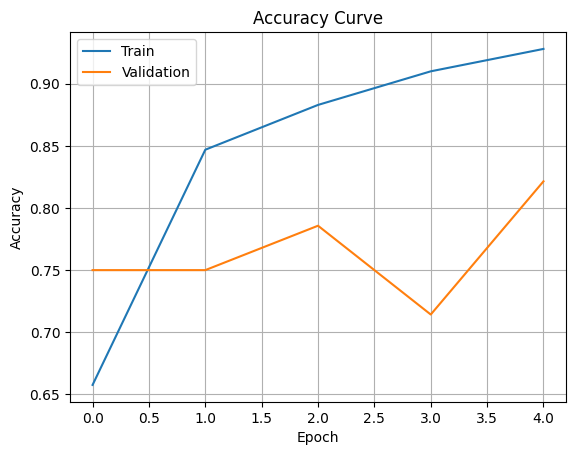

[0.2067006677389145, 0.9142857193946838, 0.9411764740943909, 0.8888888955116272, 0.9705882668495178, 16.0, 16.0, 1.0, 2.0] 0.9147836963335673 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


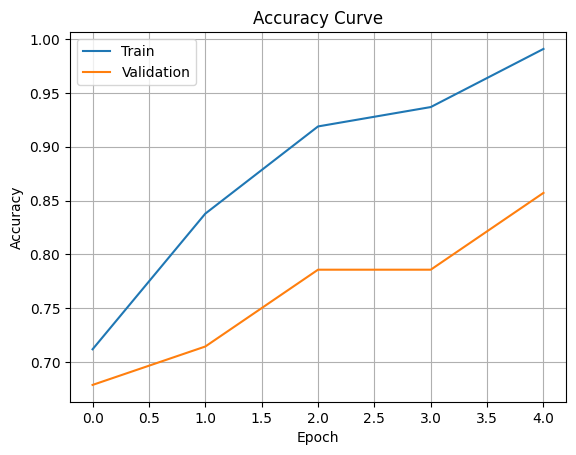

[0.48150160908699036, 0.8571428656578064, 0.8095238208770752, 0.9444444179534912, 0.9428104162216187, 17.0, 13.0, 4.0, 1.0] 0.8703703681627909 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


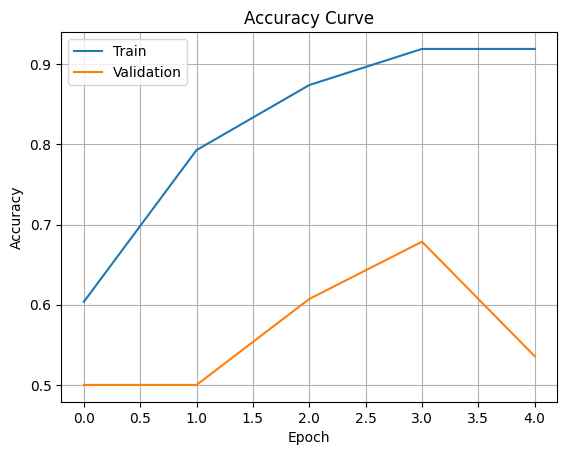

[1.271995186805725, 0.6571428775787354, 0.6000000238418579, 1.0, 0.9313725829124451, 18.0, 5.0, 12.0, 0.0] 0.7523809671401978 [5, 0.0, 0.0, 0.0, 0.0, True, True, 'Nadam', 8, 3]


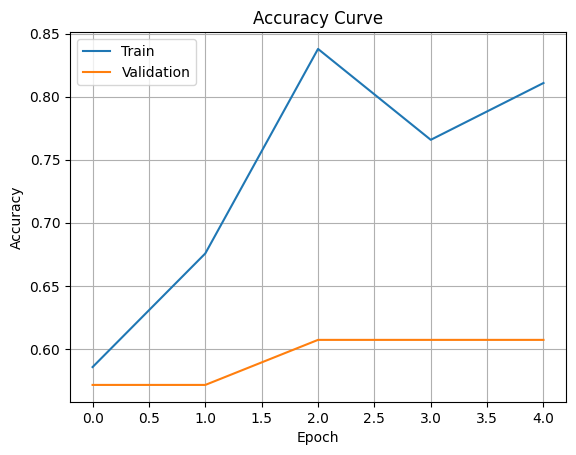

[1.1351794004440308, 0.6285714507102966, 0.5806451439857483, 1.0, 0.9297385811805725, 18.0, 4.0, 13.0, 0.0] 0.7364055315653483 [0, 0.2, 0.0, 0.2, 0.0, False, True, 'Adam', 8, 25]


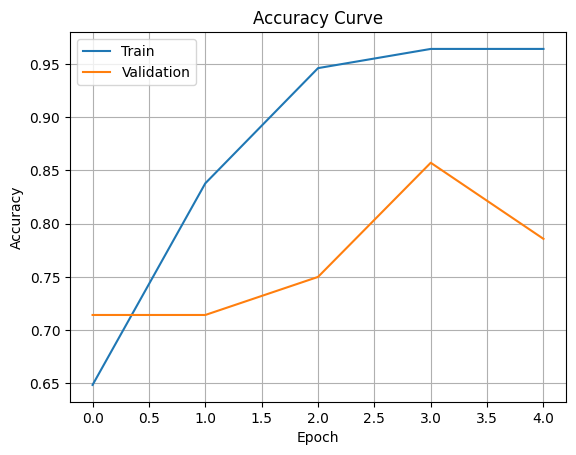

[0.3278995156288147, 0.8857142925262451, 0.9375, 0.8333333134651184, 0.9411764740943909, 15.0, 16.0, 1.0, 3.0] 0.8855158686637878 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


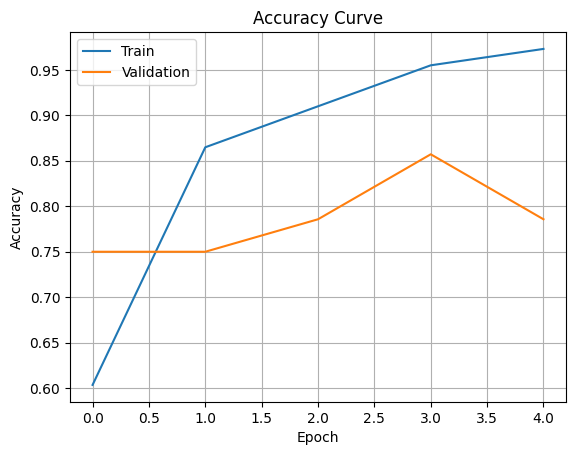

[0.314012348651886, 0.9142857193946838, 0.8571428656578064, 1.0, 0.970588207244873, 18.0, 14.0, 3.0, 0.0] 0.9238095283508301 [6, 0.0, 0.0, 0.0, 0.0, True, True, 'Nadam', 8, 0]


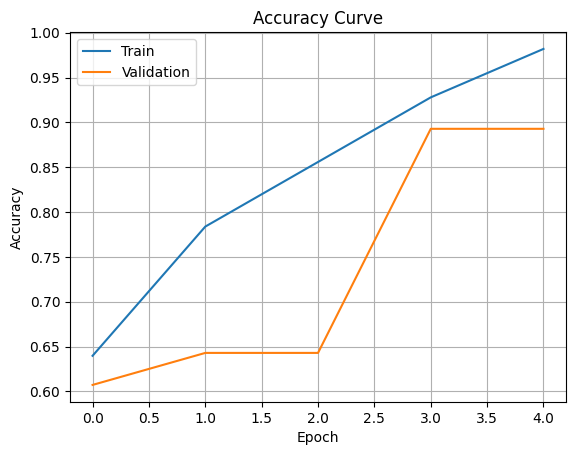

[0.25932326912879944, 0.8857142925262451, 0.8888888955116272, 0.8888888955116272, 0.9575163722038269, 16.0, 15.0, 2.0, 2.0] 0.8878306945164999 [7, 0.0, 0.1, 0.0, 0.0, True, False, 'Adam', 8, 0]


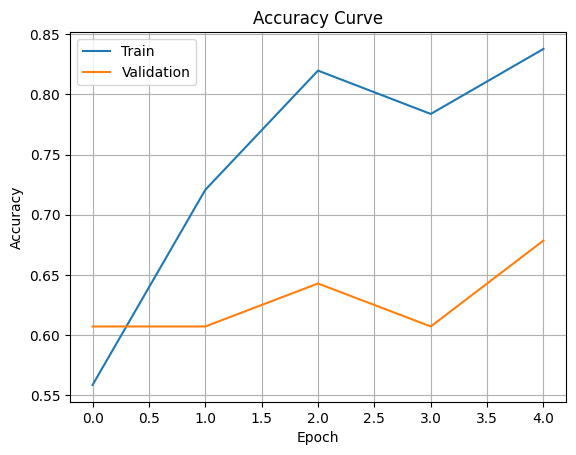

[0.39975541830062866, 0.7714285850524902, 0.692307710647583, 1.0, 0.9754902124404907, 18.0, 9.0, 8.0, 0.0] 0.8212454319000244 [20, 0.1, 0.2, 0.1, 0.1, True, True, 'SGD', 16, 15]


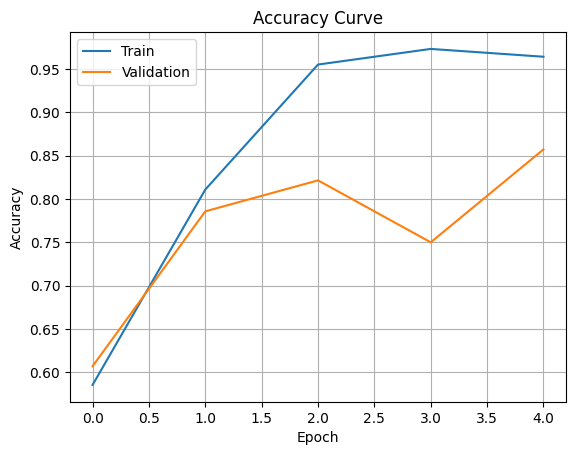

[0.5481399893760681, 0.8571428656578064, 0.8095238208770752, 0.9444444179534912, 0.9183007478713989, 17.0, 13.0, 4.0, 1.0] 0.8703703681627909 [2, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


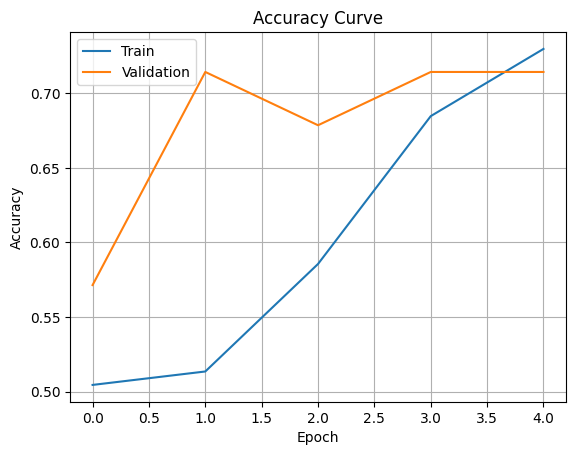

[0.6049044132232666, 0.6857143044471741, 0.8888888955116272, 0.4444444477558136, 0.7598039507865906, 8.0, 16.0, 1.0, 10.0] 0.6730158825715383 [30, 0.2, 0.2, 0.2, 0.2, False, False, 'SGD', 64, 25]


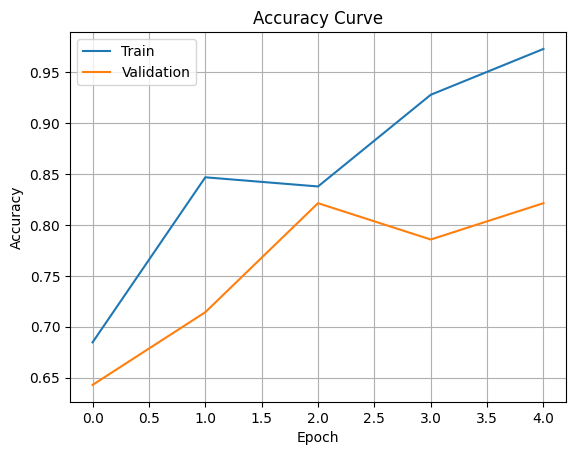

[0.22604559361934662, 0.9142857193946838, 0.8947368264198303, 0.9444444179534912, 0.9738562703132629, 17.0, 15.0, 2.0, 1.0] 0.9178223212560018 [2, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


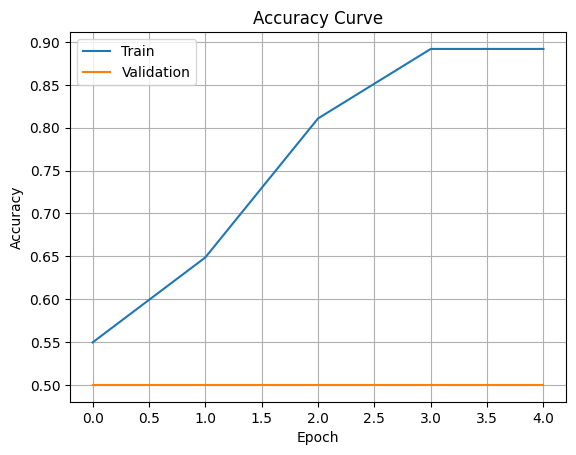

[138.7284698486328, 0.5142857432365417, 0.5142857432365417, 1.0, 0.5, 18.0, 0.0, 17.0, 0.0] 0.6761904954910278 [13, 0.2, 0.2, 0.2, 0.1, True, False, 'Nadam', 64, 25]


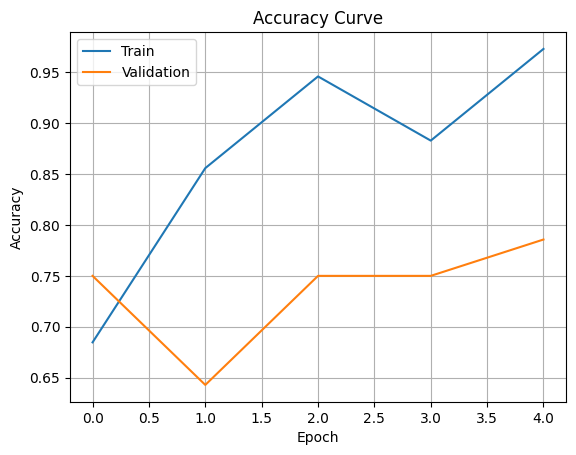

[0.24694514274597168, 0.8285714387893677, 0.9285714030265808, 0.7222222089767456, 0.9673202633857727, 13.0, 16.0, 1.0, 5.0] 0.8264550169308981 [4, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


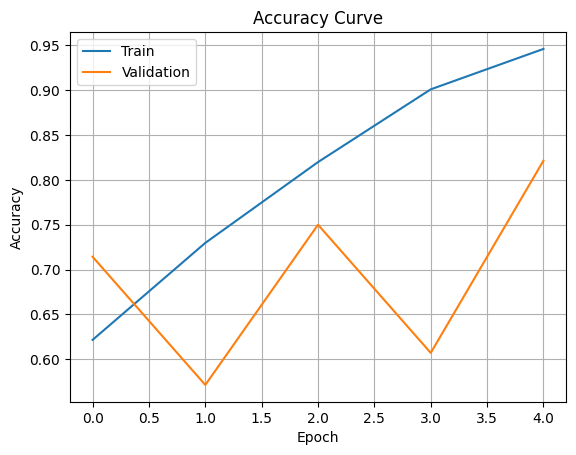

[0.37602144479751587, 0.8571428656578064, 0.8421052694320679, 0.8888888955116272, 0.9346405267715454, 16.0, 14.0, 3.0, 2.0] 0.8627123435338339 [0, 0.0, 0.2, 0.1, 0.0, True, False, 'Adam', 8, 2]


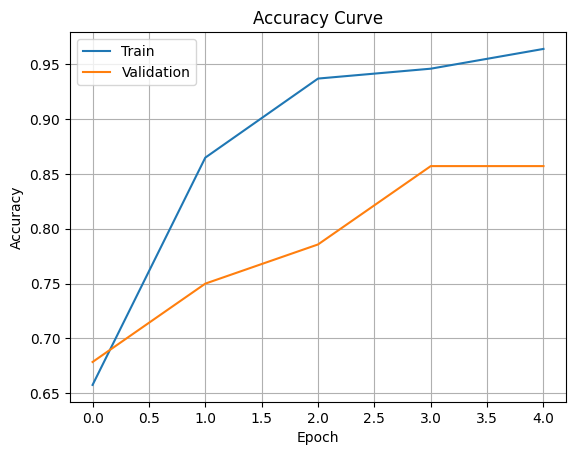

[0.2430146336555481, 0.8857142925262451, 0.8888888955116272, 0.8888888955116272, 0.9738562107086182, 16.0, 15.0, 2.0, 2.0] 0.8878306945164999 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


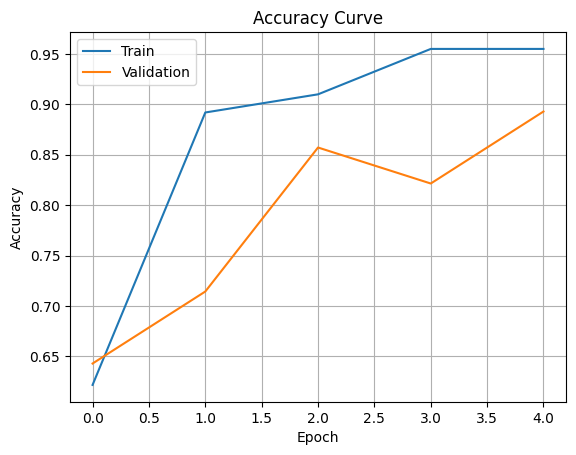

[0.41018247604370117, 0.8285714387893677, 0.7727272510528564, 0.9444444179534912, 0.9101307392120361, 17.0, 12.0, 5.0, 1.0] 0.8485810359319051 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


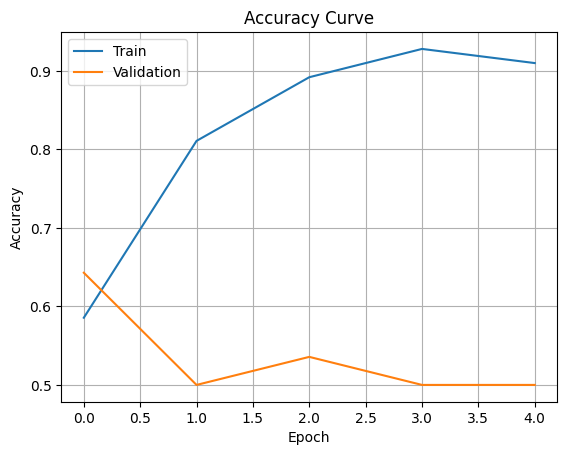

[1.7174872159957886, 0.5428571701049805, 0.529411792755127, 1.0, 0.8333333730697632, 18.0, 1.0, 16.0, 0.0] 0.6907563209533691 [5, 0.0, 0.0, 0.0, 0.0, True, True, 'Nadam', 8, 3]


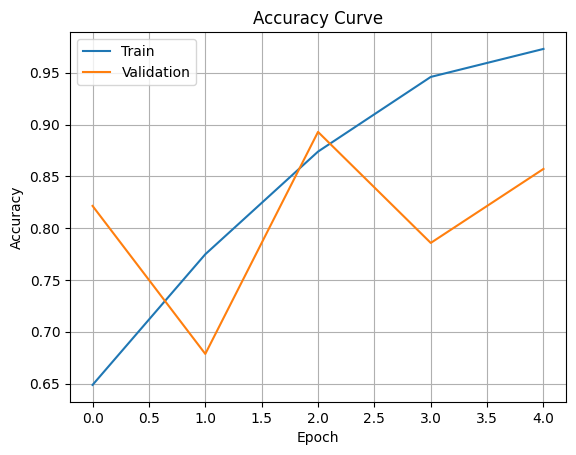

[0.27387377619743347, 0.8571428656578064, 0.8095238208770752, 0.9444444179534912, 0.9738562107086182, 17.0, 13.0, 4.0, 1.0] 0.8703703681627909 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


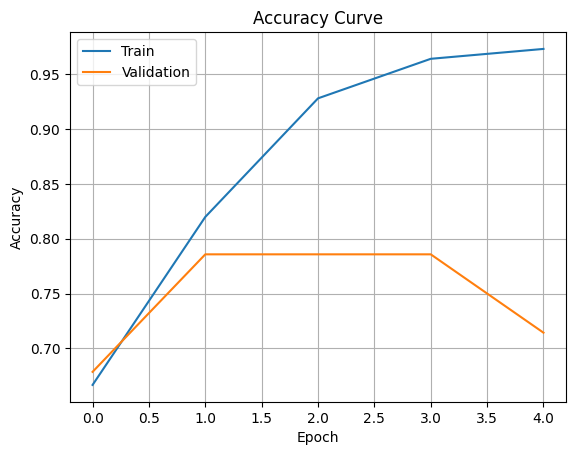

[0.7087911367416382, 0.800000011920929, 0.7894737124443054, 0.8333333134651184, 0.8627451062202454, 15.0, 13.0, 4.0, 3.0] 0.8076023459434509 [7, 0.0, 0.1, 0.0, 0.0, True, False, 'Adam', 8, 0]


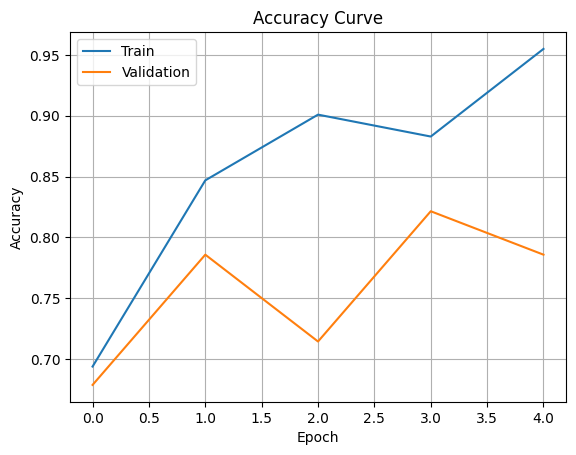

[0.5290342569351196, 0.8571428656578064, 0.8421052694320679, 0.8888888955116272, 0.9313726425170898, 16.0, 14.0, 3.0, 2.0] 0.8627123435338339 [2, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


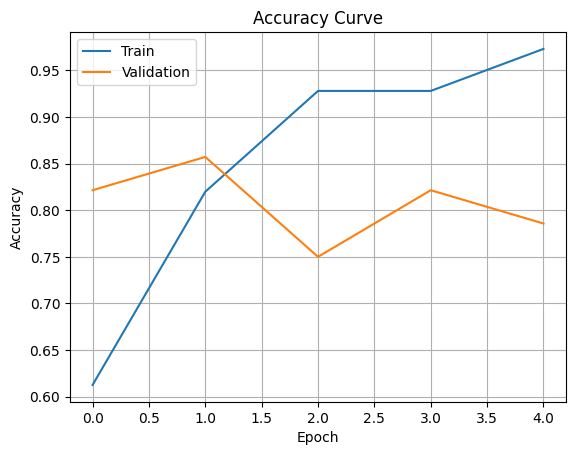

[0.20809407532215118, 0.9142857193946838, 0.8947368264198303, 0.9444444179534912, 0.9771242141723633, 17.0, 15.0, 2.0, 1.0] 0.9178223212560018 [2, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


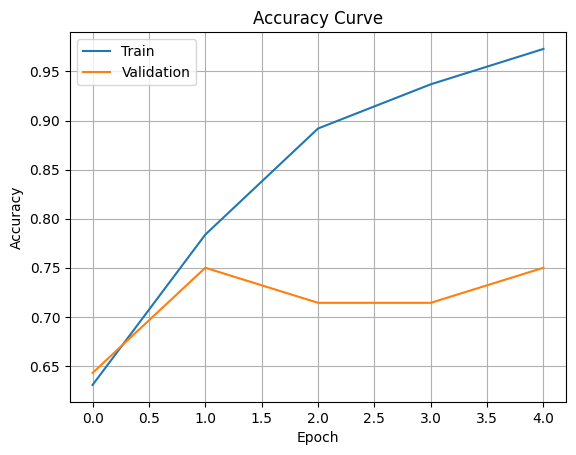

[0.4478278160095215, 0.7428571581840515, 0.6666666865348816, 1.0, 0.9330065250396729, 18.0, 8.0, 9.0, 0.0] 0.803174614906311 [4, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


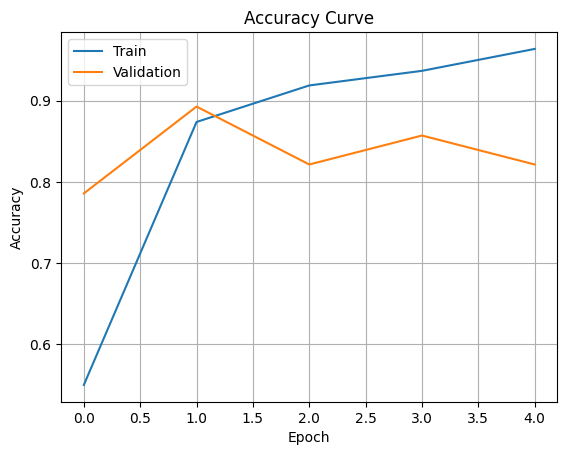

[0.20692941546440125, 0.8857142925262451, 0.8500000238418579, 0.9444444179534912, 0.9820261597633362, 17.0, 14.0, 3.0, 1.0] 0.8933862447738647 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


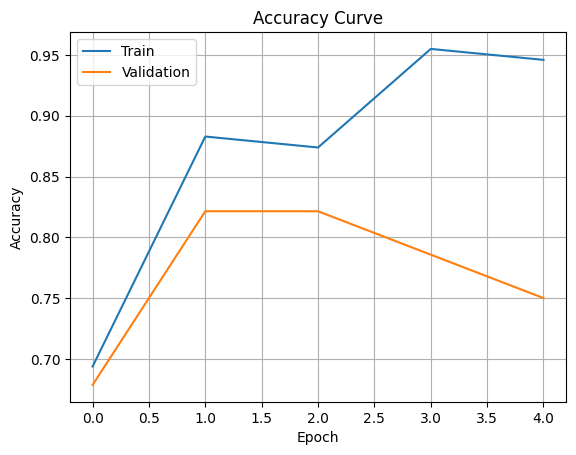

[0.7802111506462097, 0.800000011920929, 0.739130437374115, 0.9444444179534912, 0.9264707565307617, 17.0, 11.0, 6.0, 1.0] 0.8278582890828451 [2, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


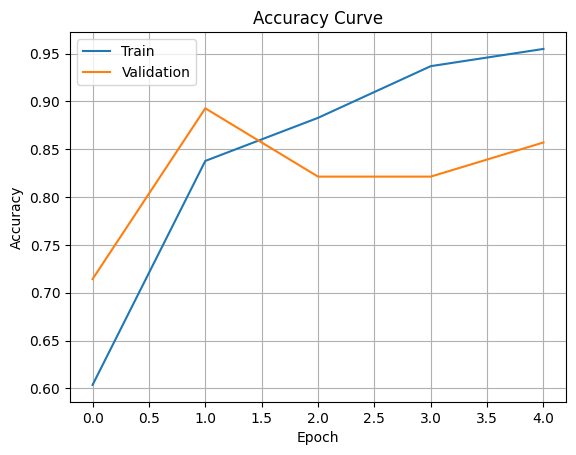

[0.8838387131690979, 0.8285714387893677, 0.75, 1.0, 0.9215686917304993, 18.0, 11.0, 6.0, 0.0] 0.8595238129297892 [2, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


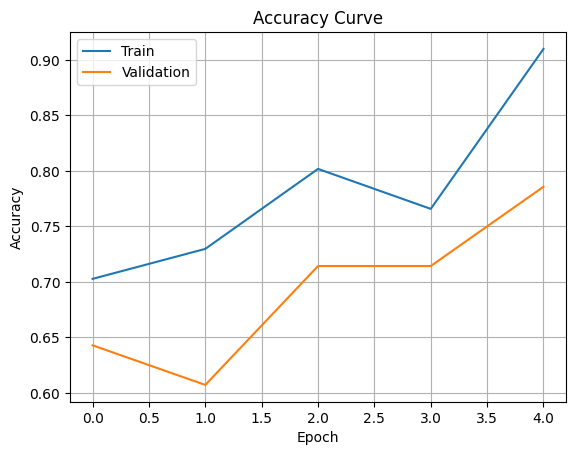

[0.36967381834983826, 0.8285714387893677, 0.7727272510528564, 0.9444444179534912, 0.944444477558136, 17.0, 12.0, 5.0, 1.0] 0.8485810359319051 [2, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 1]


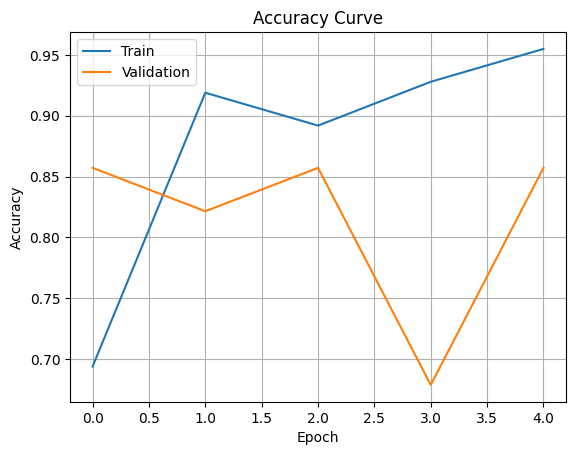

[0.768589973449707, 0.8285714387893677, 0.800000011920929, 0.8888888955116272, 0.9052287936210632, 16.0, 13.0, 4.0, 2.0] 0.8391534487406412 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


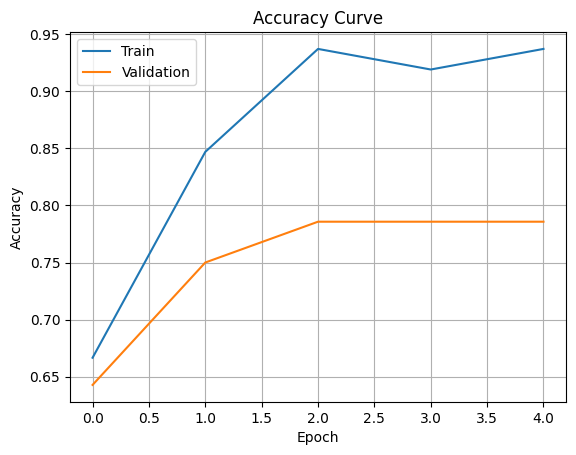

[0.38159430027008057, 0.8571428656578064, 0.9333333373069763, 0.7777777910232544, 0.9526143670082092, 14.0, 16.0, 1.0, 4.0] 0.8560846646626791 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


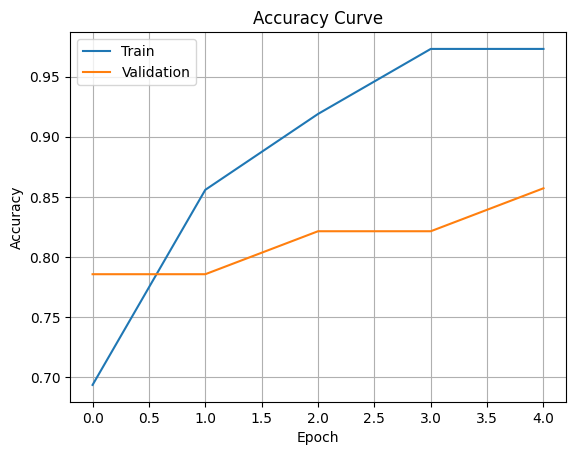

[0.2822151780128479, 0.9142857193946838, 0.8947368264198303, 0.9444444179534912, 0.9575163722038269, 17.0, 15.0, 2.0, 1.0] 0.9178223212560018 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


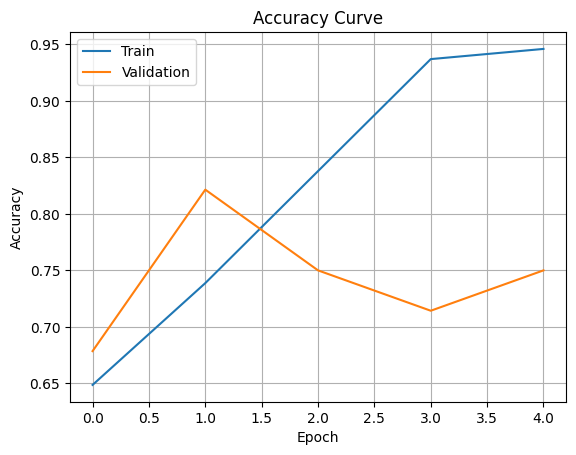

[0.39589041471481323, 0.800000011920929, 0.761904776096344, 0.8888888955116272, 0.9346404671669006, 16.0, 12.0, 5.0, 2.0] 0.8169312278429667 [15, 0.0, 0.1, 0.1, 0.0, True, False, 'Adam', 16, 0]


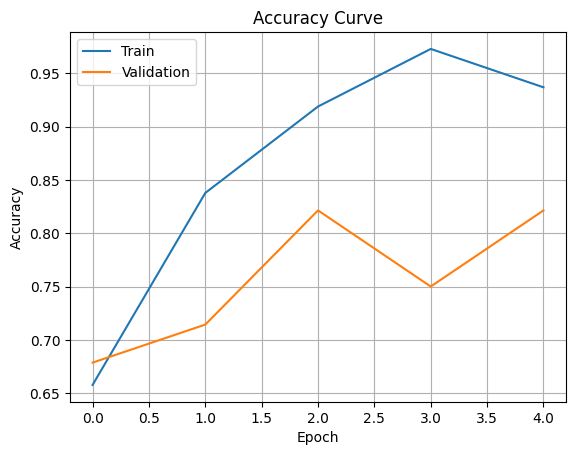

[0.18747544288635254, 0.9142857193946838, 0.9411764740943909, 0.8888888955116272, 0.9852940440177917, 16.0, 16.0, 1.0, 2.0] 0.9147836963335673 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


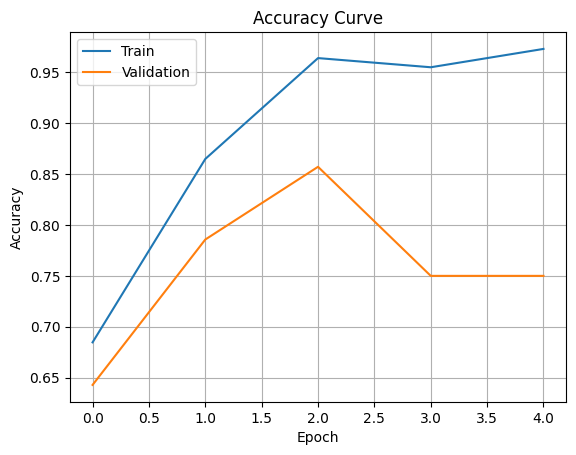

[0.31778964400291443, 0.8857142925262451, 0.9375, 0.8333333134651184, 0.9624183177947998, 15.0, 16.0, 1.0, 3.0] 0.8855158686637878 [8, 0.0, 0.0, 0.0, 0.0, True, False, 'Adam', 16, 0]


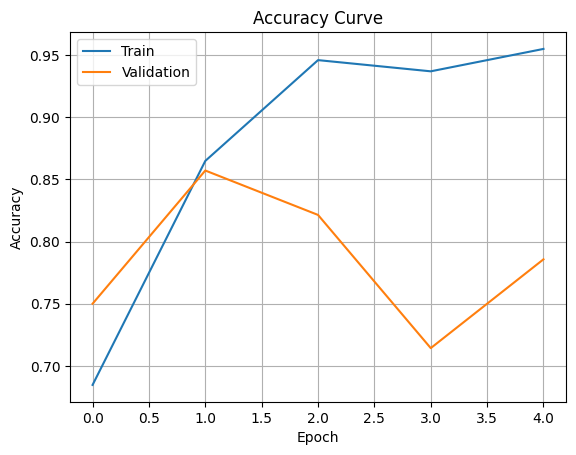

[0.5830264687538147, 0.8571428656578064, 0.782608687877655, 1.0, 0.9542484283447266, 18.0, 12.0, 5.0, 0.0] 0.8799171845118204 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


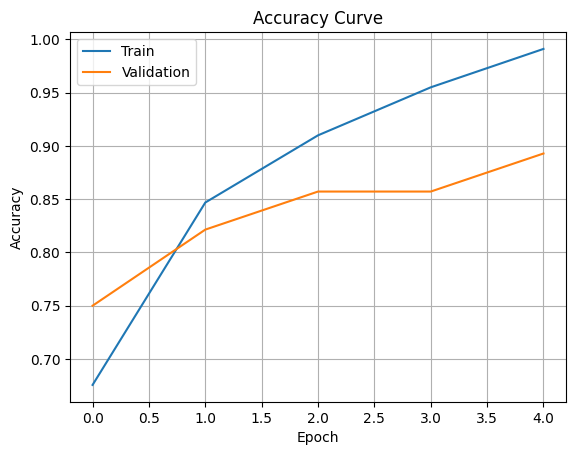

[0.3097887635231018, 0.8857142925262451, 0.8500000238418579, 0.9444444179534912, 0.9607842564582825, 17.0, 14.0, 3.0, 1.0] 0.8933862447738647 [2, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


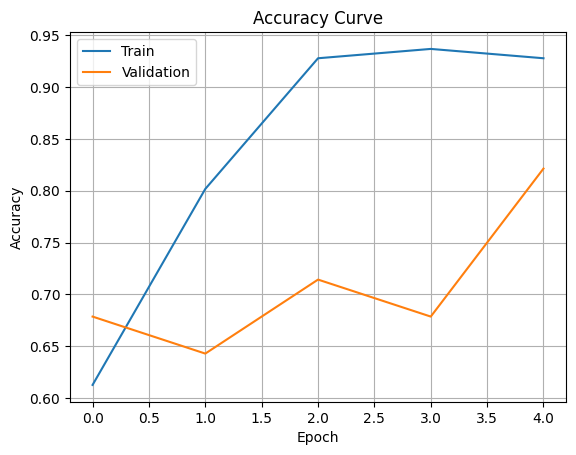

[0.3863053321838379, 0.8857142925262451, 0.8500000238418579, 0.9444444179534912, 0.9379085898399353, 17.0, 14.0, 3.0, 1.0] 0.8933862447738647 [3, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


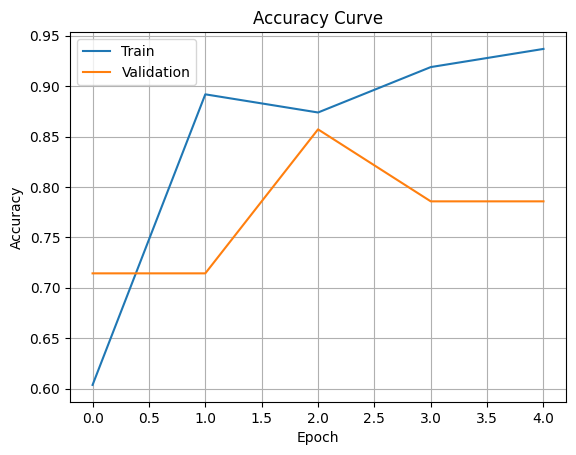

[0.36833131313323975, 0.8571428656578064, 0.8095238208770752, 0.9444444179534912, 0.9509804248809814, 17.0, 13.0, 4.0, 1.0] 0.8703703681627909 [1, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


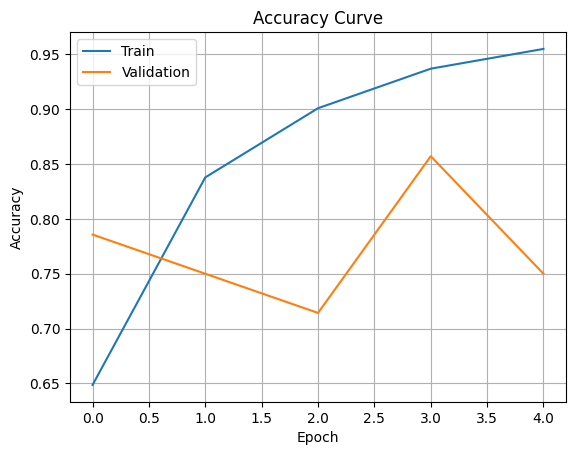

[0.3025952875614166, 0.8571428656578064, 0.8095238208770752, 0.9444444179534912, 0.9803922176361084, 17.0, 13.0, 4.0, 1.0] 0.8703703681627909 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


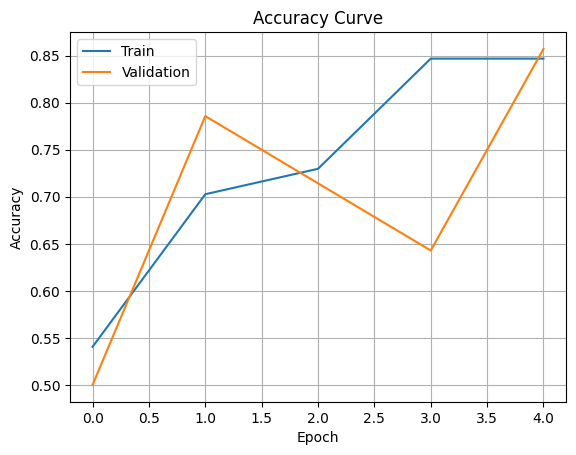

[0.6019358038902283, 0.7142857313156128, 0.6428571343421936, 1.0, 0.8643791675567627, 18.0, 7.0, 10.0, 0.0] 0.7857142885526022 [16, 0.1, 0.2, 0.2, 0.2, False, False, 'SGD', 16, 22]


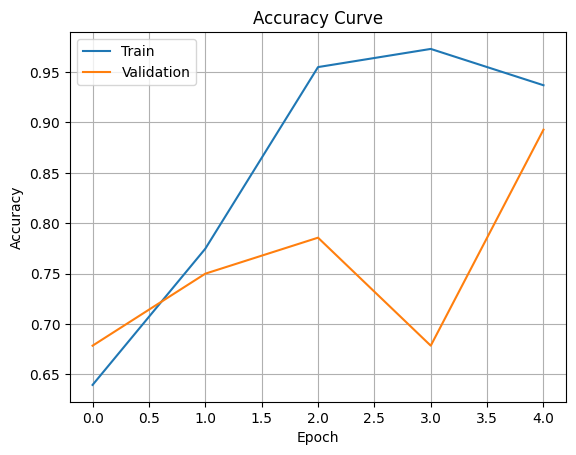

[0.22816058993339539, 0.9714285731315613, 0.9473684430122375, 1.0, 0.9754902124404907, 18.0, 16.0, 1.0, 0.0] 0.9729323387145996 [3, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


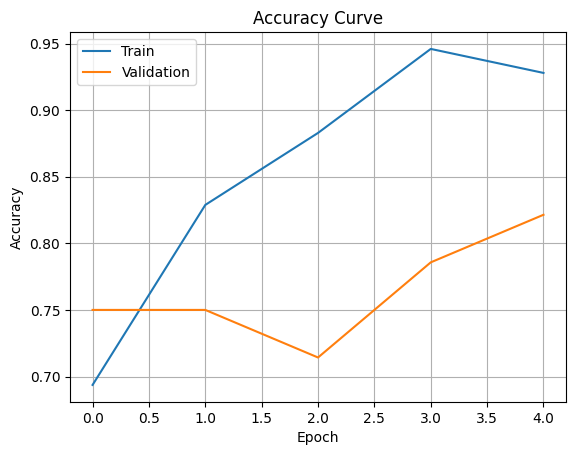

[0.36578676104545593, 0.8571428656578064, 0.8095238208770752, 0.9444444179534912, 0.944444477558136, 17.0, 13.0, 4.0, 1.0] 0.8703703681627909 [2, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


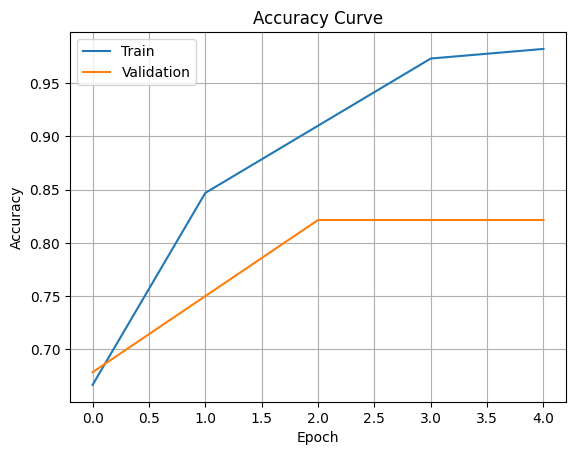

[0.258727490901947, 0.8857142925262451, 0.9375, 0.8333333134651184, 0.9607842564582825, 15.0, 16.0, 1.0, 3.0] 0.8855158686637878 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


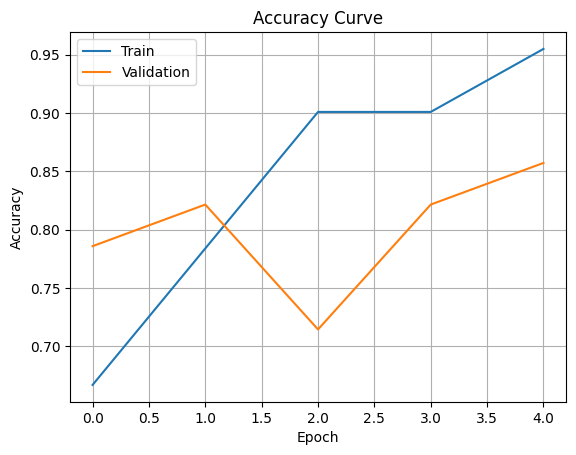

[0.18285787105560303, 0.9428571462631226, 0.9444444179534912, 0.9444444179534912, 0.9803921580314636, 17.0, 16.0, 1.0, 1.0] 0.943915327390035 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


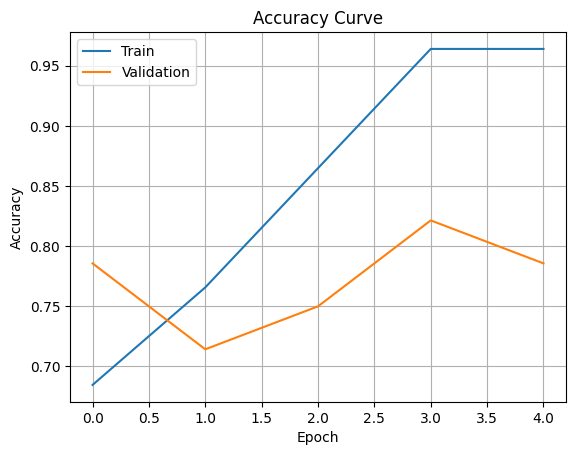

[0.36952462792396545, 0.8857142925262451, 0.8500000238418579, 0.9444444179534912, 0.944444477558136, 17.0, 14.0, 3.0, 1.0] 0.8933862447738647 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


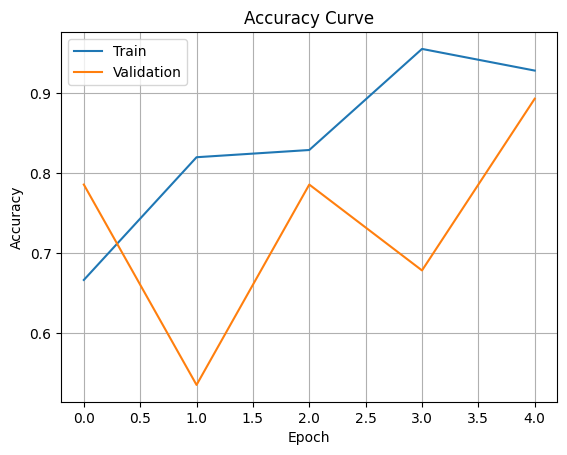

[0.25642234086990356, 0.9428571462631226, 0.8999999761581421, 1.0, 0.9836601614952087, 18.0, 15.0, 2.0, 0.0] 0.9476190408070883 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


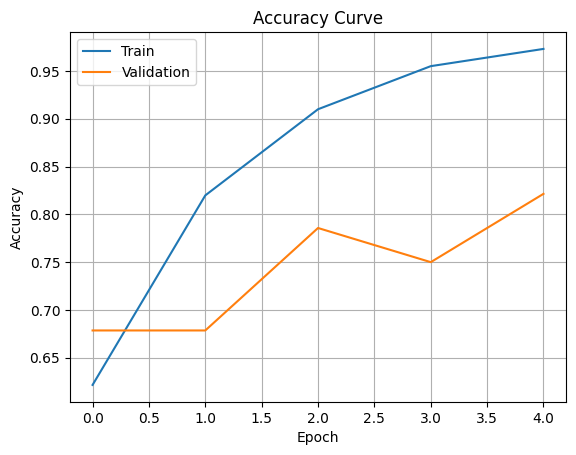

[0.27393585443496704, 0.9428571462631226, 0.9444444179534912, 0.9444444179534912, 0.952614426612854, 17.0, 16.0, 1.0, 1.0] 0.943915327390035 [3, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


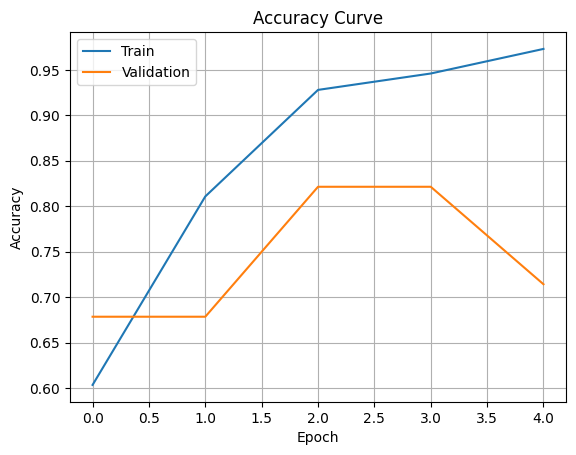

[0.26011085510253906, 0.8857142925262451, 0.8888888955116272, 0.8888888955116272, 0.9575164318084717, 16.0, 15.0, 2.0, 2.0] 0.8878306945164999 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


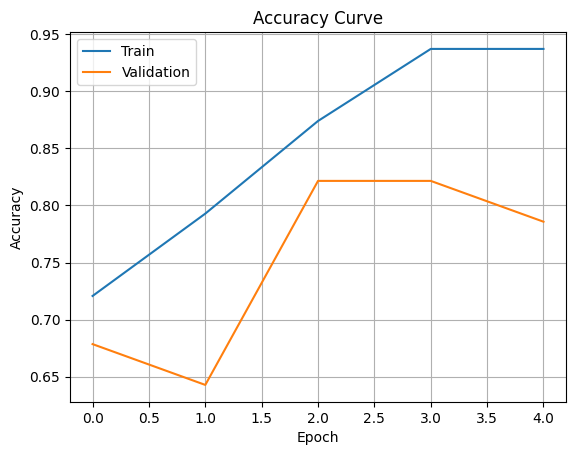

[0.44077351689338684, 0.9142857193946838, 0.9411764740943909, 0.8888888955116272, 0.9199346303939819, 16.0, 16.0, 1.0, 2.0] 0.9147836963335673 [3, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


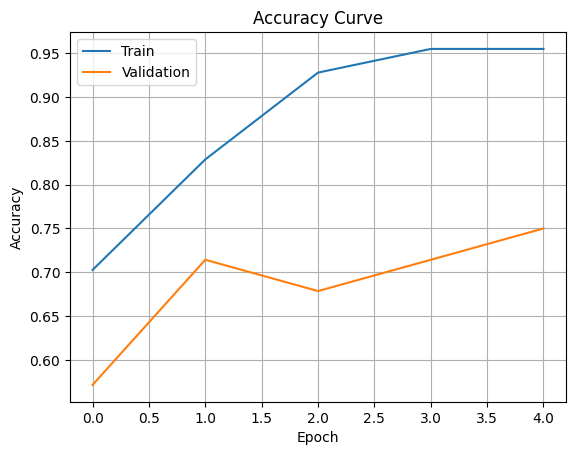

[0.47725987434387207, 0.8285714387893677, 0.7727272510528564, 0.9444444179534912, 0.944444477558136, 17.0, 12.0, 5.0, 1.0] 0.8485810359319051 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


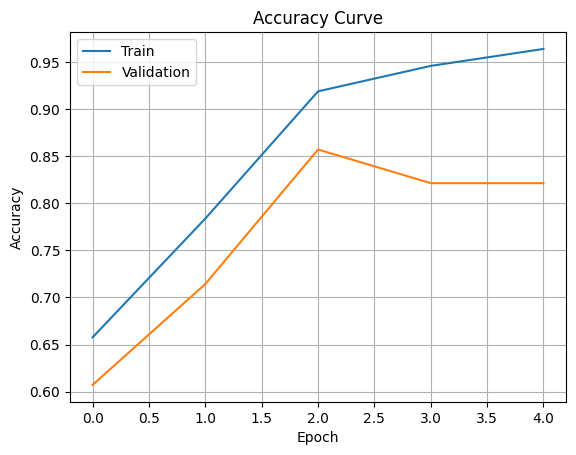

[0.5308546423912048, 0.8285714387893677, 0.7727272510528564, 0.9444444179534912, 0.9117646813392639, 17.0, 12.0, 5.0, 1.0] 0.8485810359319051 [1, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


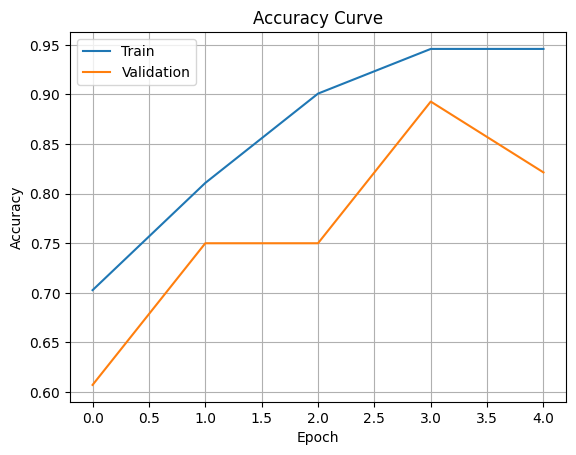

[0.19406886398792267, 0.8571428656578064, 0.8095238208770752, 0.9444444179534912, 0.9836601614952087, 17.0, 13.0, 4.0, 1.0] 0.8703703681627909 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


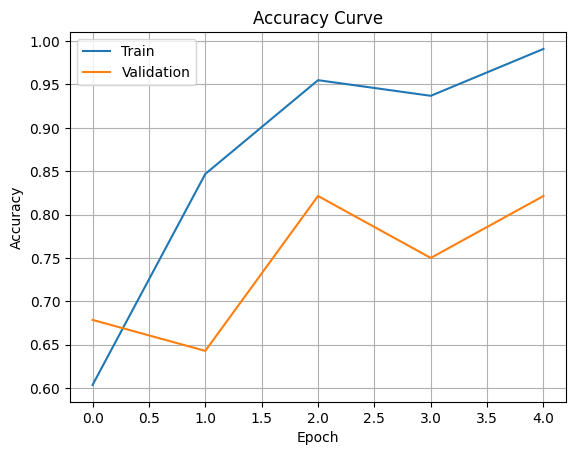

[0.47680044174194336, 0.8571428656578064, 0.8095238208770752, 0.9444444179534912, 0.9199346899986267, 17.0, 13.0, 4.0, 1.0] 0.8703703681627909 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


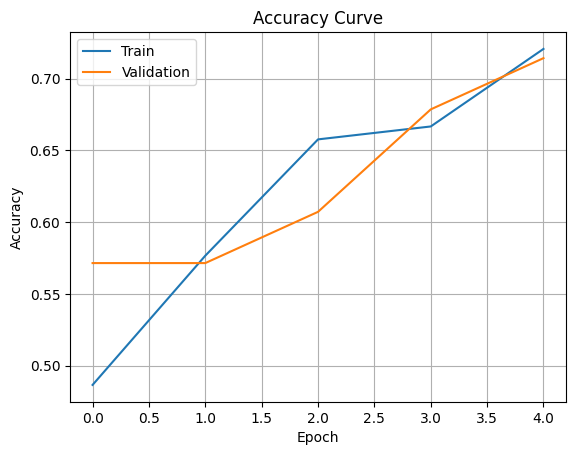

[0.5075629949569702, 0.7714285850524902, 0.8571428656578064, 0.6666666865348816, 0.8611111044883728, 12.0, 15.0, 2.0, 6.0] 0.7650793790817261 [30, 0.2, 0.2, 0.2, 0.2, True, False, 'SGD', 64, 25]


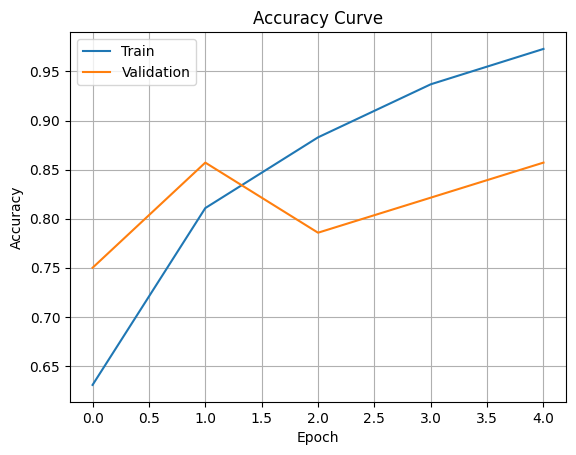

[0.5999186038970947, 0.800000011920929, 0.739130437374115, 0.9444444179534912, 0.9428104758262634, 17.0, 11.0, 6.0, 1.0] 0.8278582890828451 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


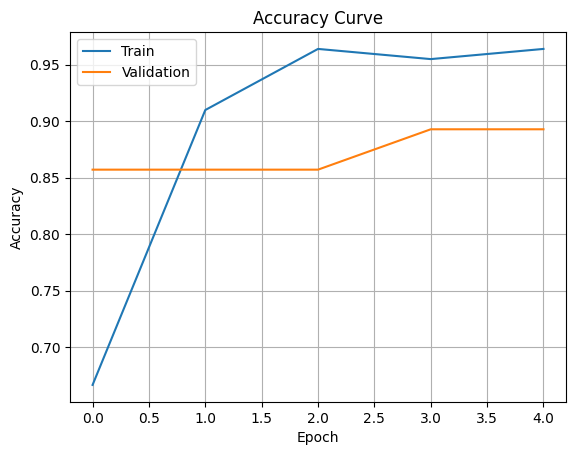

[0.2962959110736847, 0.8857142925262451, 0.8500000238418579, 0.9444444179534912, 0.9460784196853638, 17.0, 14.0, 3.0, 1.0] 0.8933862447738647 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


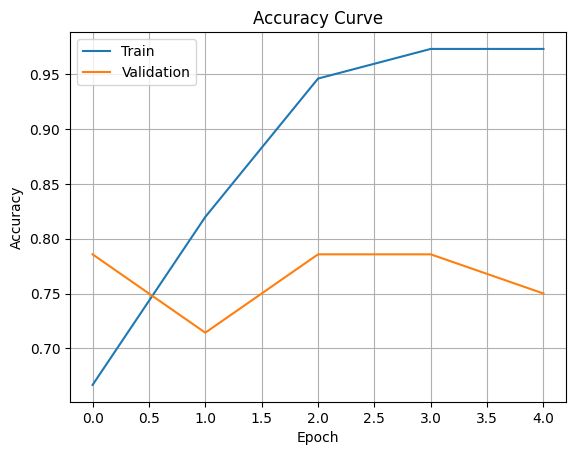

[0.4579837918281555, 0.8571428656578064, 0.8421052694320679, 0.8888888955116272, 0.9395424723625183, 16.0, 14.0, 3.0, 2.0] 0.8627123435338339 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


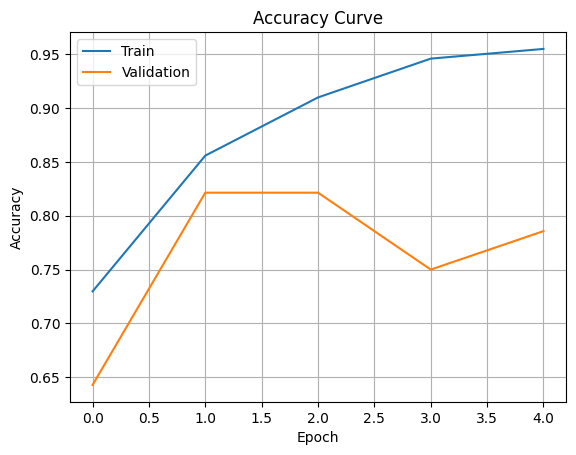

[0.2461133748292923, 0.9142857193946838, 0.8947368264198303, 0.9444444179534912, 0.9673202633857727, 17.0, 15.0, 2.0, 1.0] 0.9178223212560018 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


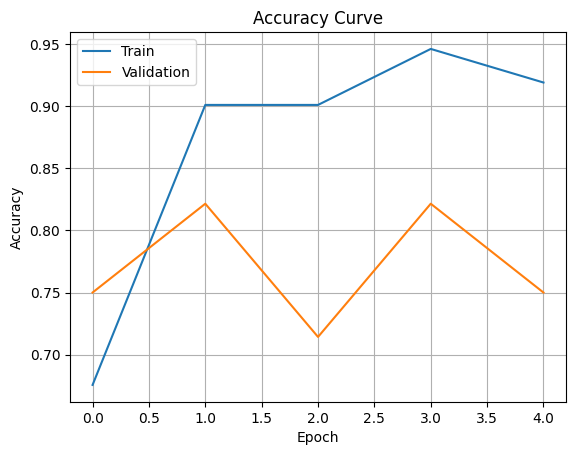

[1.1168197393417358, 0.7428571581840515, 0.6666666865348816, 1.0, 0.8676470518112183, 18.0, 8.0, 9.0, 0.0] 0.803174614906311 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


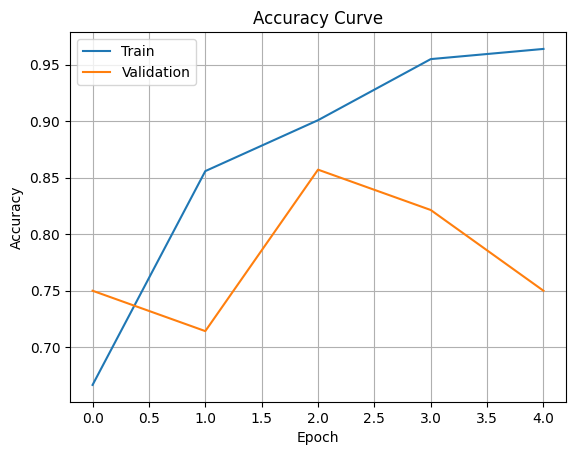

[0.38075321912765503, 0.8285714387893677, 0.800000011920929, 0.8888888955116272, 0.936274528503418, 16.0, 13.0, 4.0, 2.0] 0.8391534487406412 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


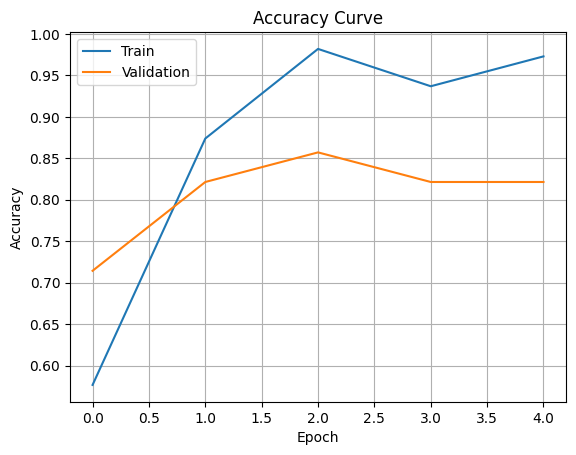

[0.1712539792060852, 0.8857142925262451, 0.8888888955116272, 0.8888888955116272, 0.9836601614952087, 16.0, 15.0, 2.0, 2.0] 0.8878306945164999 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


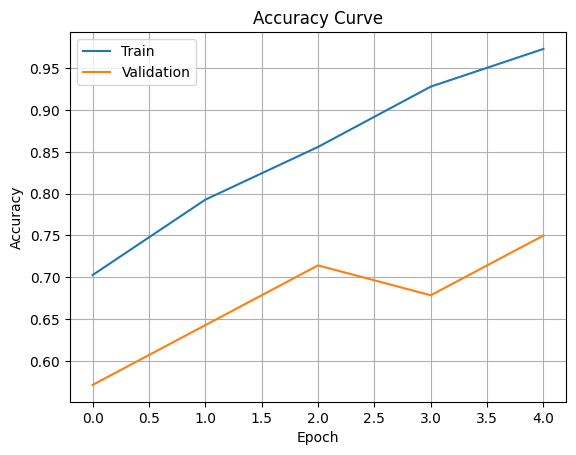

[0.4259773790836334, 0.8857142925262451, 0.8888888955116272, 0.8888888955116272, 0.9493464231491089, 16.0, 15.0, 2.0, 2.0] 0.8878306945164999 [1, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


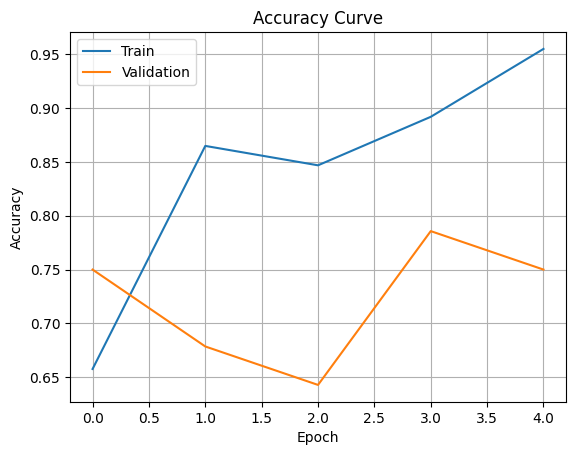

[0.3181339204311371, 0.9142857193946838, 0.8947368264198303, 0.9444444179534912, 0.9558824300765991, 17.0, 15.0, 2.0, 1.0] 0.9178223212560018 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


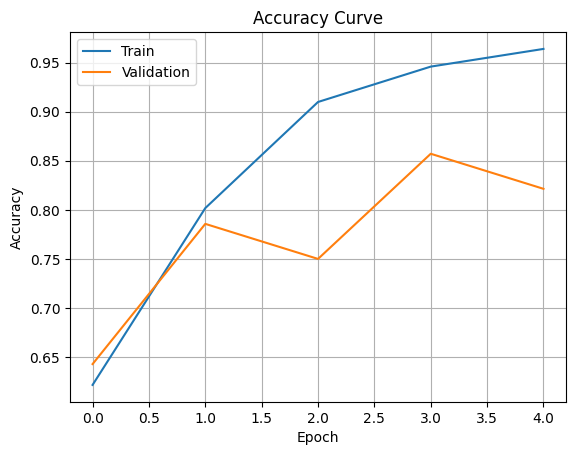

[0.41800063848495483, 0.8857142925262451, 0.8500000238418579, 0.9444444179534912, 0.9330064654350281, 17.0, 14.0, 3.0, 1.0] 0.8933862447738647 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


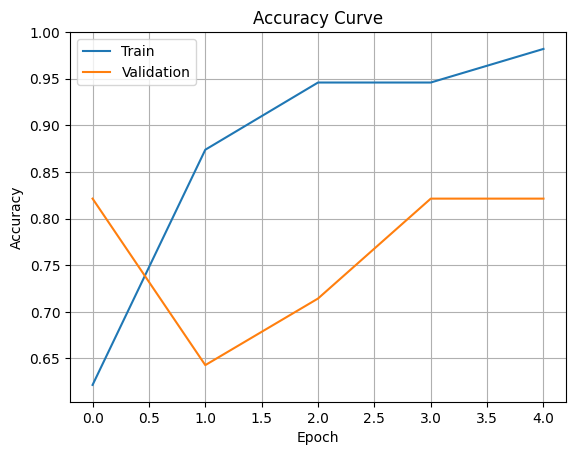

[0.6203765273094177, 0.800000011920929, 0.761904776096344, 0.8888888955116272, 0.9117646217346191, 16.0, 12.0, 5.0, 2.0] 0.8169312278429667 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


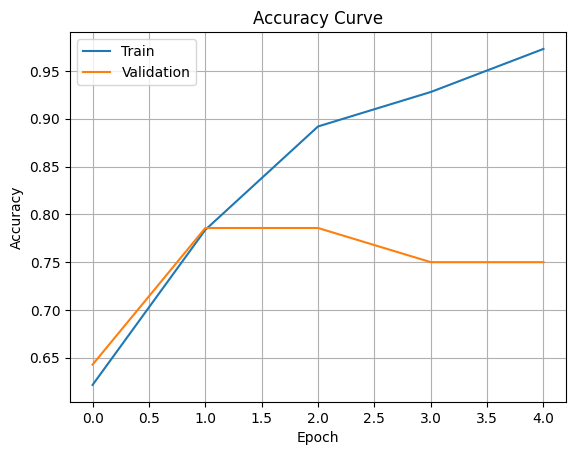

[0.6707195043563843, 0.8571428656578064, 0.8095238208770752, 0.9444444179534912, 0.8856210112571716, 17.0, 13.0, 4.0, 1.0] 0.8703703681627909 [1, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


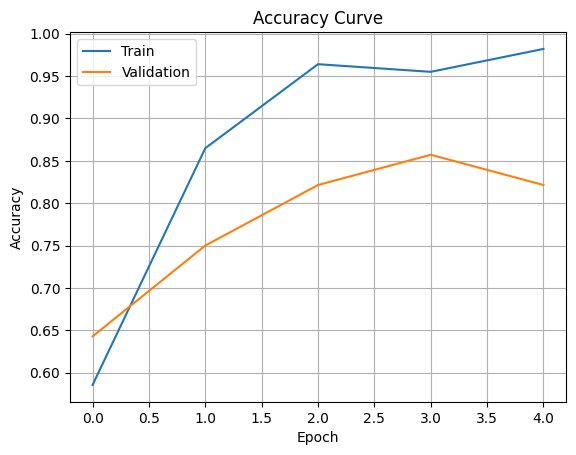

[0.2980809509754181, 0.9714285731315613, 0.9473684430122375, 1.0, 0.9575163125991821, 18.0, 16.0, 1.0, 0.0] 0.9729323387145996 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


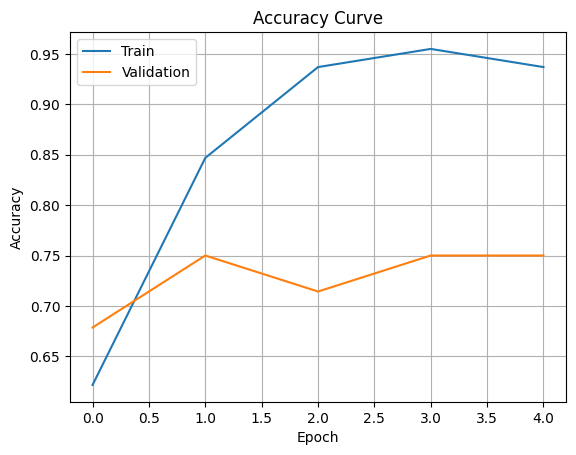

[0.24939343333244324, 0.9428571462631226, 1.0, 0.8888888955116272, 0.9477124214172363, 16.0, 17.0, 0.0, 2.0] 0.9439153472582499 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


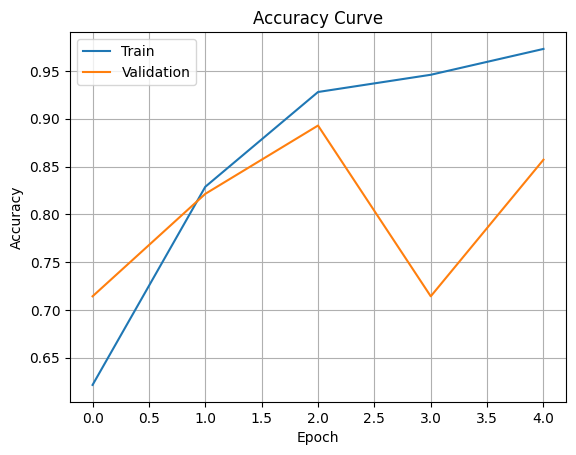

[0.29553818702697754, 0.9142857193946838, 0.8571428656578064, 1.0, 0.9673202633857727, 18.0, 14.0, 3.0, 0.0] 0.9238095283508301 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


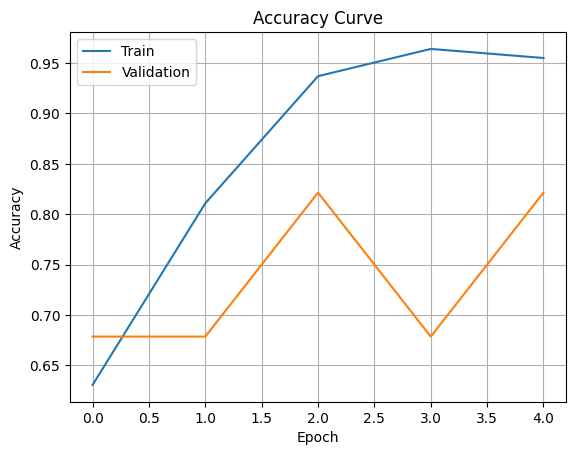

[0.378214031457901, 0.9142857193946838, 0.8571428656578064, 1.0, 0.9558823704719543, 18.0, 14.0, 3.0, 0.0] 0.9238095283508301 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


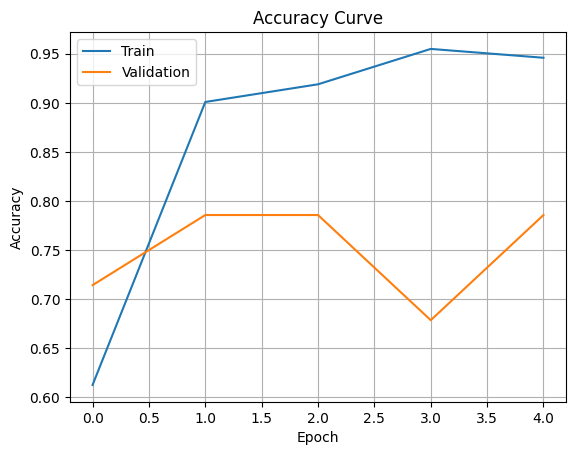

[0.4430069923400879, 0.8571428656578064, 0.8095238208770752, 0.9444444179534912, 0.9215686917304993, 17.0, 13.0, 4.0, 1.0] 0.8703703681627909 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


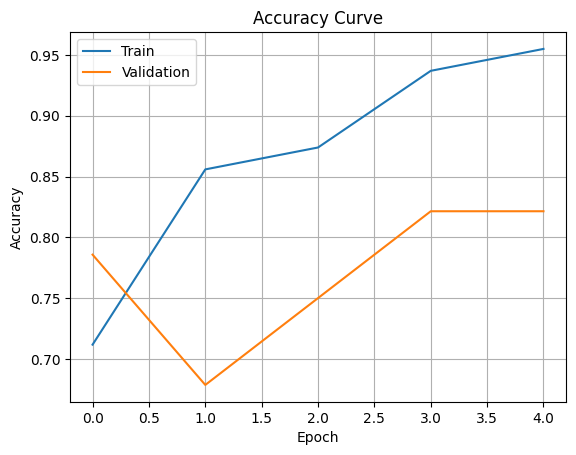

[1.3177437782287598, 0.8285714387893677, 0.7727272510528564, 0.9444444179534912, 0.9215686917304993, 17.0, 12.0, 5.0, 1.0] 0.8485810359319051 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


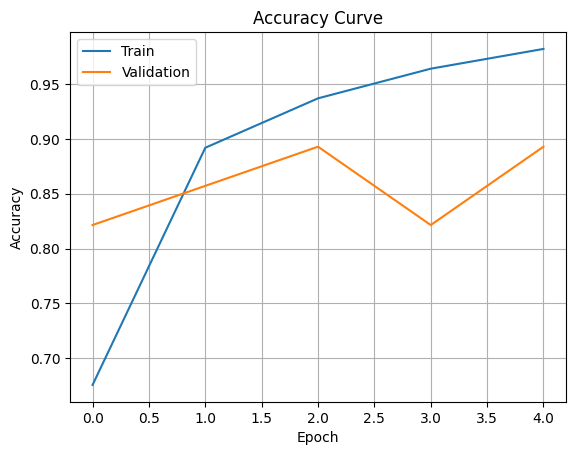

[0.3118797540664673, 0.8857142925262451, 0.8500000238418579, 0.9444444179534912, 0.9836601614952087, 17.0, 14.0, 3.0, 1.0] 0.8933862447738647 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


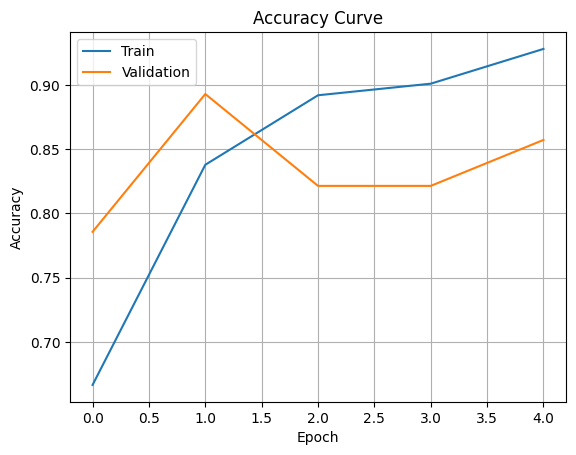

[0.2767464518547058, 0.8571428656578064, 0.8823529481887817, 0.8333333134651184, 0.9444445371627808, 15.0, 15.0, 2.0, 3.0] 0.8576097091039022 [2, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


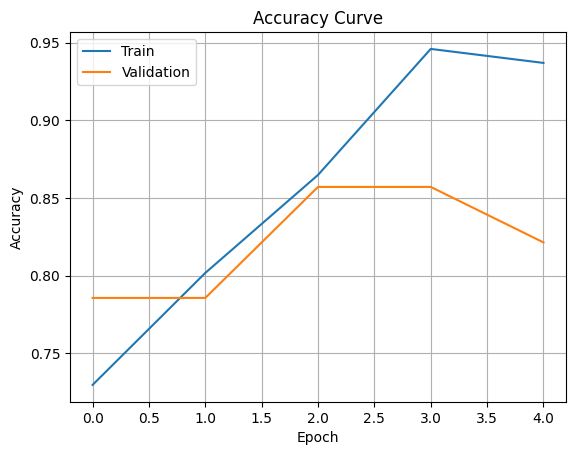

[0.2230762243270874, 0.8571428656578064, 0.8421052694320679, 0.8888888955116272, 0.9738562107086182, 16.0, 14.0, 3.0, 2.0] 0.8627123435338339 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


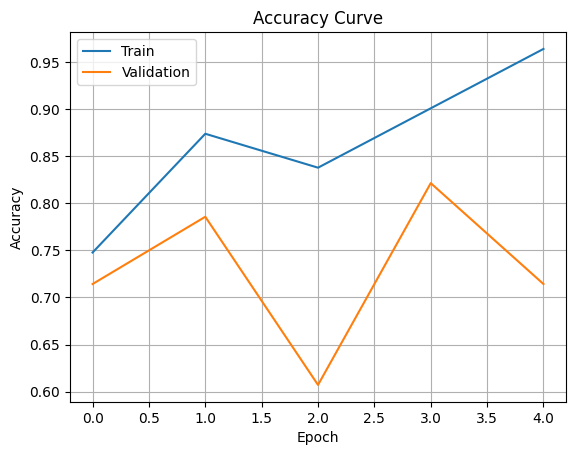

[0.6478435397148132, 0.8285714387893677, 0.7727272510528564, 0.9444444179534912, 0.9215685725212097, 17.0, 12.0, 5.0, 1.0] 0.8485810359319051 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


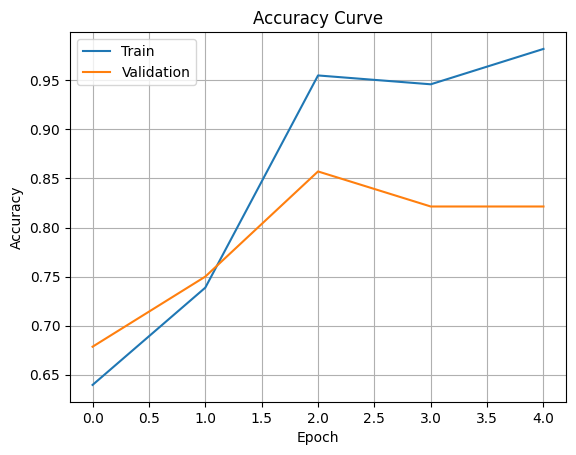

[0.42709165811538696, 0.9142857193946838, 0.8571428656578064, 1.0, 0.952614426612854, 18.0, 14.0, 3.0, 0.0] 0.9238095283508301 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


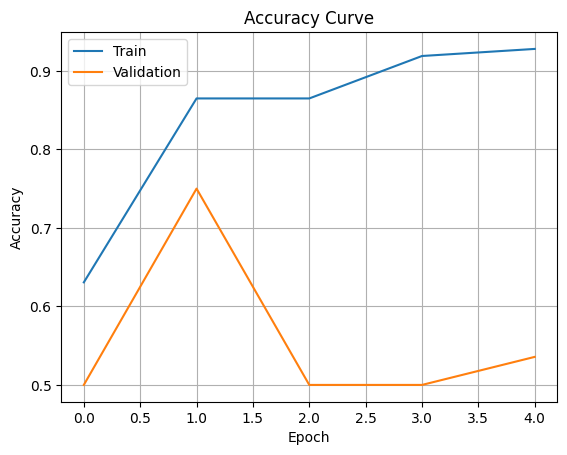

[0.49180227518081665, 0.7714285850524902, 0.7777777910232544, 0.7777777910232544, 0.8578431606292725, 14.0, 13.0, 4.0, 4.0] 0.7756613890329996 [6, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 16, 4]


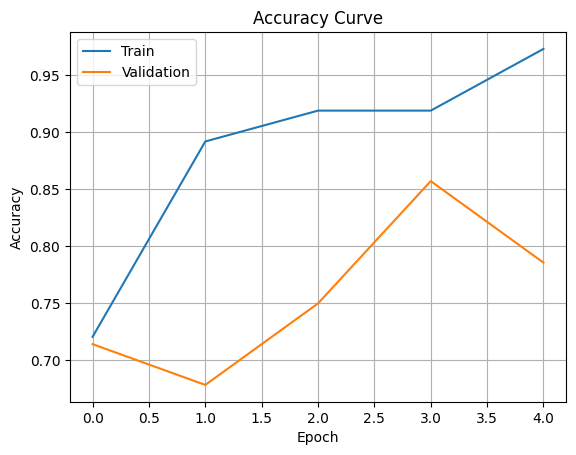

[0.4771806299686432, 0.8571428656578064, 0.8095238208770752, 0.9444444179534912, 0.9444444179534912, 17.0, 13.0, 4.0, 1.0] 0.8703703681627909 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


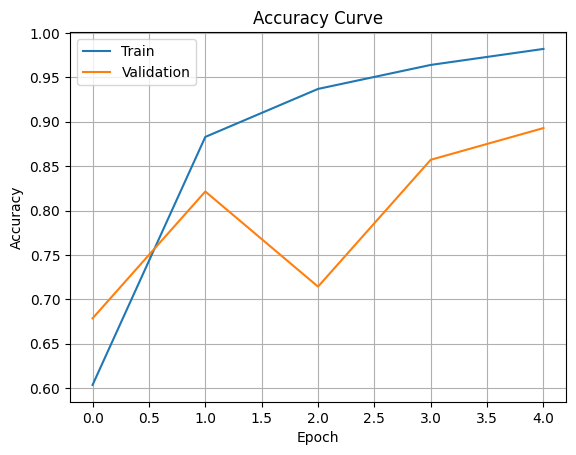

[0.3657951354980469, 0.9142857193946838, 0.8947368264198303, 0.9444444179534912, 0.9526143670082092, 17.0, 15.0, 2.0, 1.0] 0.9178223212560018 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Nadam', 8, 0]


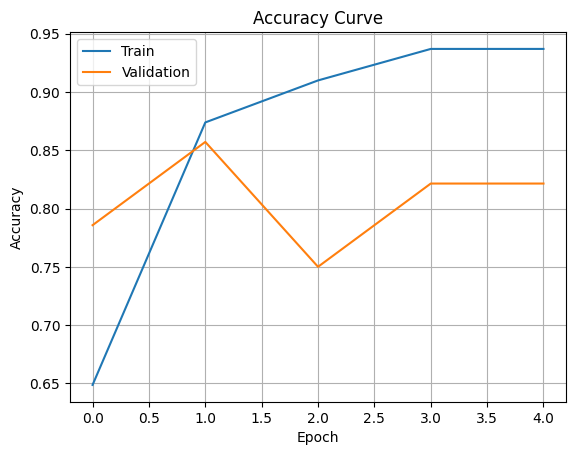

[0.5811851024627686, 0.6857143044471741, 0.6296296119689941, 0.9444444179534912, 0.9575163722038269, 17.0, 7.0, 10.0, 1.0] 0.7532627781232198 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


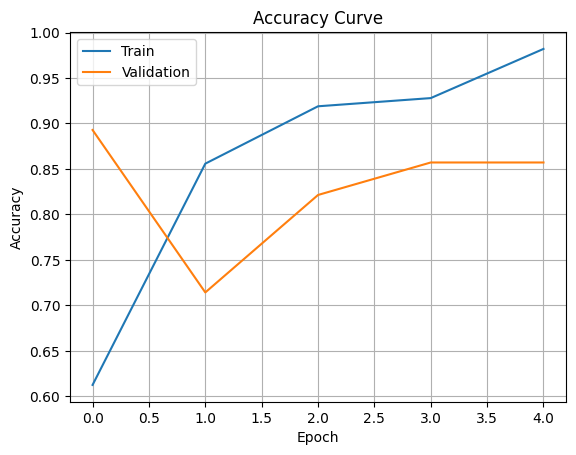

[0.29613277316093445, 0.8571428656578064, 0.9333333373069763, 0.7777777910232544, 0.9689542055130005, 14.0, 16.0, 1.0, 4.0] 0.8560846646626791 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


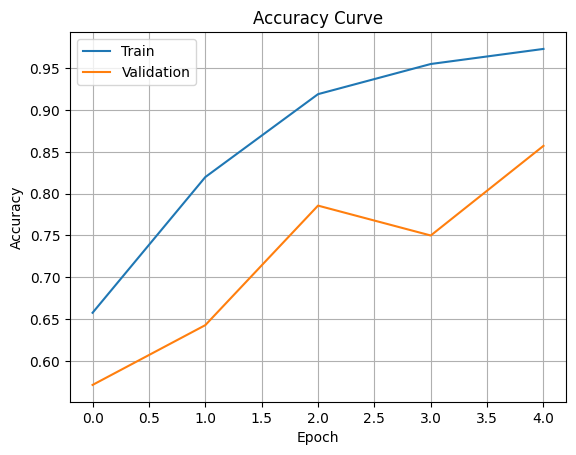

[0.33879807591438293, 0.9142857193946838, 0.8947368264198303, 0.9444444179534912, 0.9493464231491089, 17.0, 15.0, 2.0, 1.0] 0.9178223212560018 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


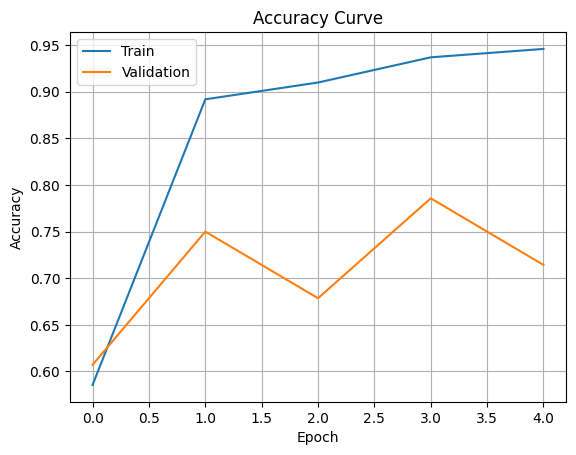

[0.9016233682632446, 0.7714285850524902, 0.7083333134651184, 0.9444444179534912, 0.9133987426757812, 17.0, 10.0, 7.0, 1.0] 0.8080687721570333 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


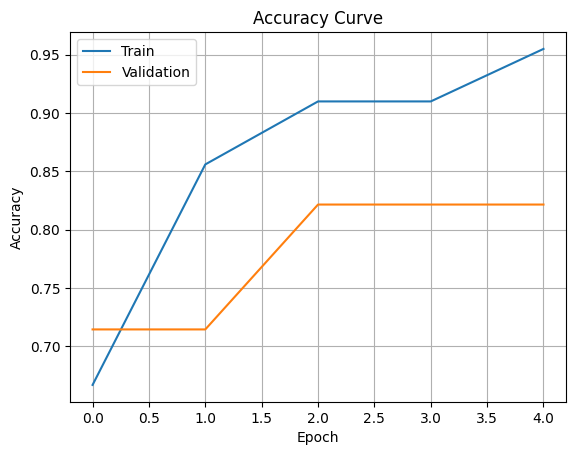

[0.36138471961021423, 0.8857142925262451, 0.8888888955116272, 0.8888888955116272, 0.936274528503418, 16.0, 15.0, 2.0, 2.0] 0.8878306945164999 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


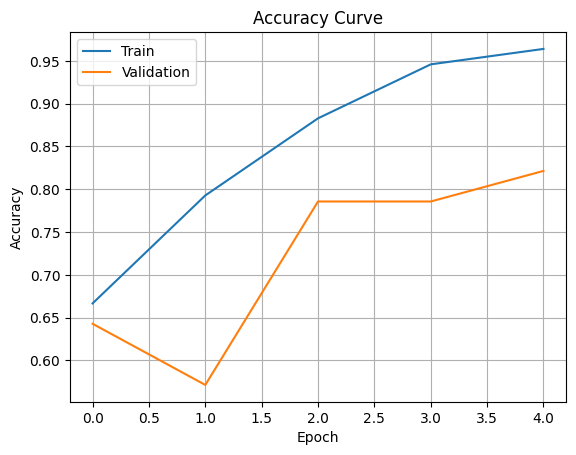

[0.29266056418418884, 0.9428571462631226, 0.8999999761581421, 1.0, 0.9509803652763367, 18.0, 15.0, 2.0, 0.0] 0.9476190408070883 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


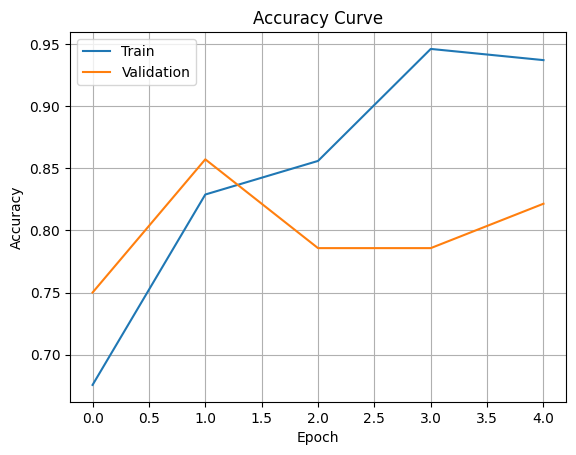

[0.6247475743293762, 0.800000011920929, 0.739130437374115, 0.9444444179534912, 0.9722222089767456, 17.0, 11.0, 6.0, 1.0] 0.8278582890828451 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


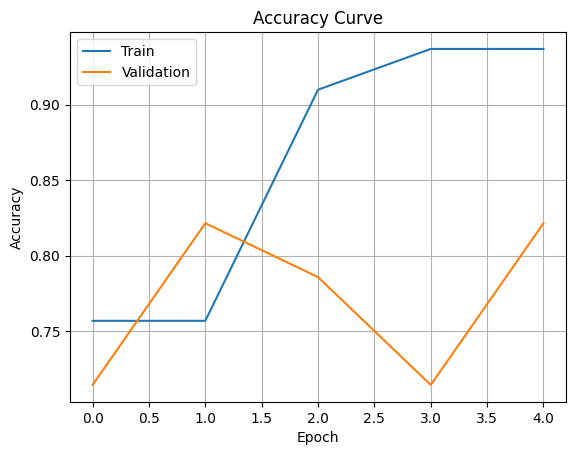

[0.6306969523429871, 0.8857142925262451, 0.8181818127632141, 1.0, 0.9150327444076538, 18.0, 13.0, 4.0, 0.0] 0.9012987017631531 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


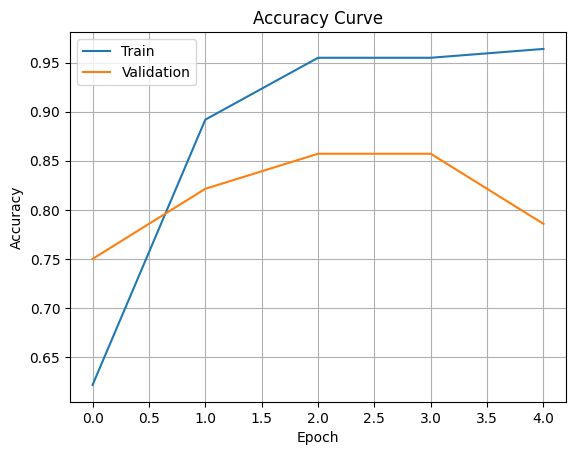

[0.1777290552854538, 0.9428571462631226, 0.9444444179534912, 0.9444444179534912, 0.9771241545677185, 17.0, 16.0, 1.0, 1.0] 0.943915327390035 [0, 0.0, 0.0, 0.0, 0.0, True, True, 'Adam', 8, 0]


In [ ]:
# Repeat
bestSolutions = []
bestScores = []
for iterationNumber in range(NO_OF_ITERATIONS):
  scores = []
  for i in range(len(population)):
    score = FitnessFunction(population[i])
    scores.append(score)

  newPopulation = PopulationUpdating(population, scores, iterationNumber)

  # LOGGING THE DATA
  populationScoresPath = os.path.join(PROJECT_PATH, "Population.csv")
  # T #, S #, ......, Score
  file = open(populationScoresPath, "a")
  for i in range(len(population)):
    data = f"{iterationNumber + 1},{i + 1},"
    data += ",".join([str(el) for el in population[i]])
    data += f",{scores[i]}"
    data += "\n"
    file.write(data)
  file.close()

  bestIndex = np.argmax(scores)
  bestSolution = population[bestIndex].copy()
  bestScore = scores[bestIndex]
  bestSolutions.append(bestSolution)
  bestScores.append(bestScore)

  population = newPopulation.copy()

In [ ]:
# LOGGING THE DATA
bestSolutionsPath = os.path.join(PROJECT_PATH, "BestSolutions.csv")
file = open(bestSolutionsPath, "w")
for i in range(len(bestSolutions)):
  data = ",".join([str(el) for el in bestSolutions[i]])
  data += f",{bestScores[i]}"
  data += "\n"
  file.write(data)
file.close()
